<a href="https://colab.research.google.com/github/harshad317/AutoInland-Vehicle-Insurance-Claim-Challenge/blob/main/Zindi_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install optuna
#!pip install catboost
#!pip install feature_engine
#!pip install category_encoders
#!pip install rfpimp
#!pip install interpret
#!pip install featuretools

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut, LeaveOneGroupOut, TimeSeriesSplit, RepeatedStratifiedKFold
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import MeanEncoder, RareLabelEncoder, PRatioEncoder
from itertools import combinations
import pickle
from rfpimp import permutation_importances
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import optuna
#from ngboost import NGBClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler, OneHotEncoder, KBinsDiscretizer

from IPython.display import display
%matplotlib inline
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
from category_encoders import BinaryEncoder
from tqdm.notebook import tqdm
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from category_encoders.woe import WOEEncoder
import featuretools as ft

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
vars = pd.read_csv('/content/VariableDefinitions.csv')
sub = pd.read_csv('/content/SampleSubmission.csv')

In [ ]:
vars

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [ ]:
(train.isnull().sum() *100)/len(train)

ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Gender                     2.972100
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
Car_Category              30.946270
Subject_Car_Colour        57.637222
Subject_Car_Make          20.498386
LGA_Name                  53.613710
State                     53.713056
ProductName                0.000000
target                     0.000000
dtype: float64

In [ ]:
cat_cols = [
 'Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [ ]:
def plot_category_percent_of_target(col):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    cat_percent = train[[col, 'target']].groupby(col, as_index=False).mean()
    cat_size = train[col].value_counts().reset_index(drop=False)
    cat_size.columns = [col, 'count']
    cat_percent = cat_percent.merge(cat_size, on=col, how='left')
    cat_percent['target'] = cat_percent['target'].fillna(0)
    cat_percent = cat_percent.sort_values(by='count', ascending=False)[:20]
    sns.barplot(ax=ax, x='target', y=col, data=cat_percent, order=cat_percent[col])

    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_percent['count'].values[i]), (p.get_width(), p.get_y()+0.5), fontsize=20)

    plt.xlabel('% of target(target)')
    plt.ylabel(col)
    plt.show()

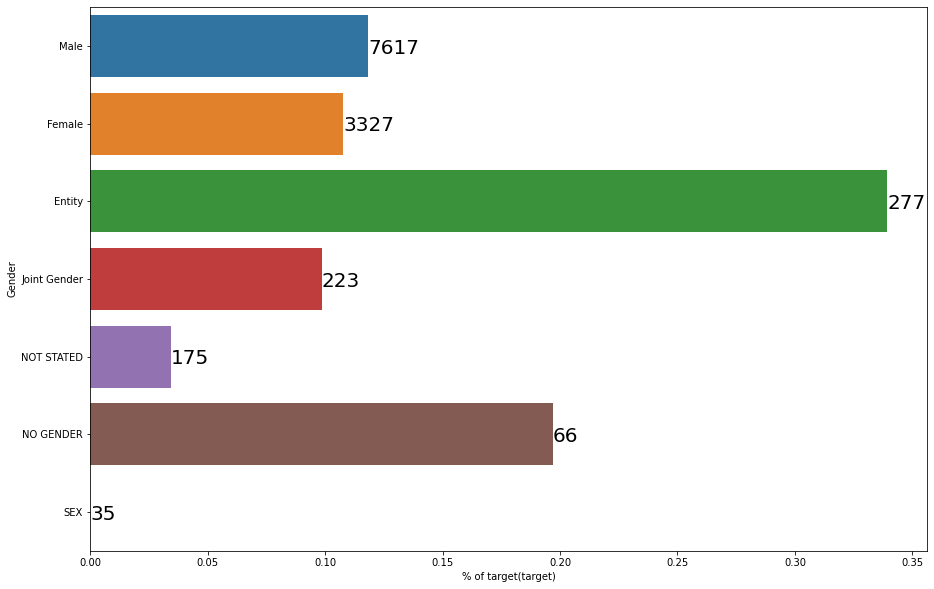

In [ ]:
col = cat_cols[0]
plot_category_percent_of_target(col)

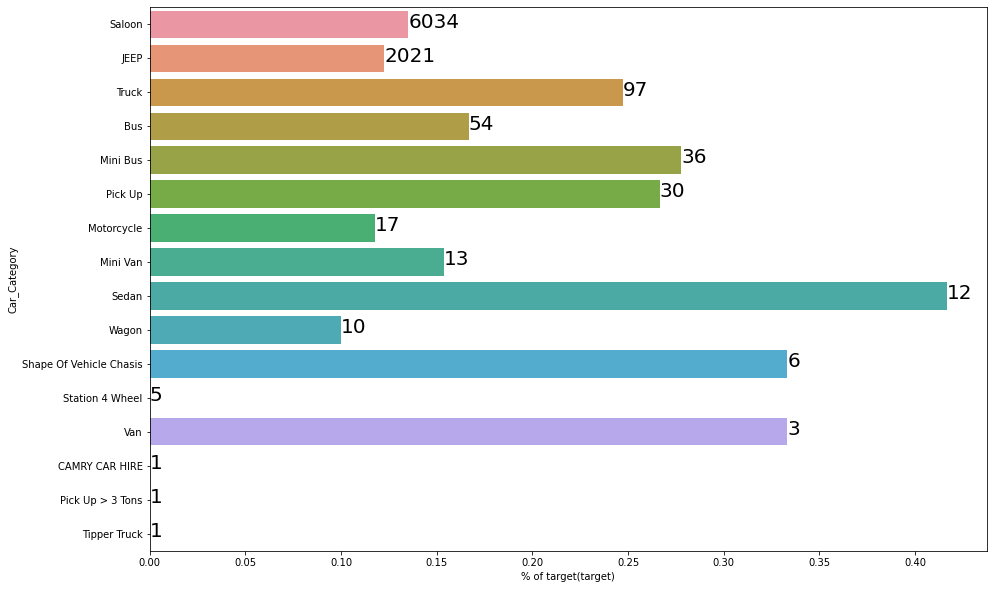

In [ ]:
col = cat_cols[1]
plot_category_percent_of_target(col)

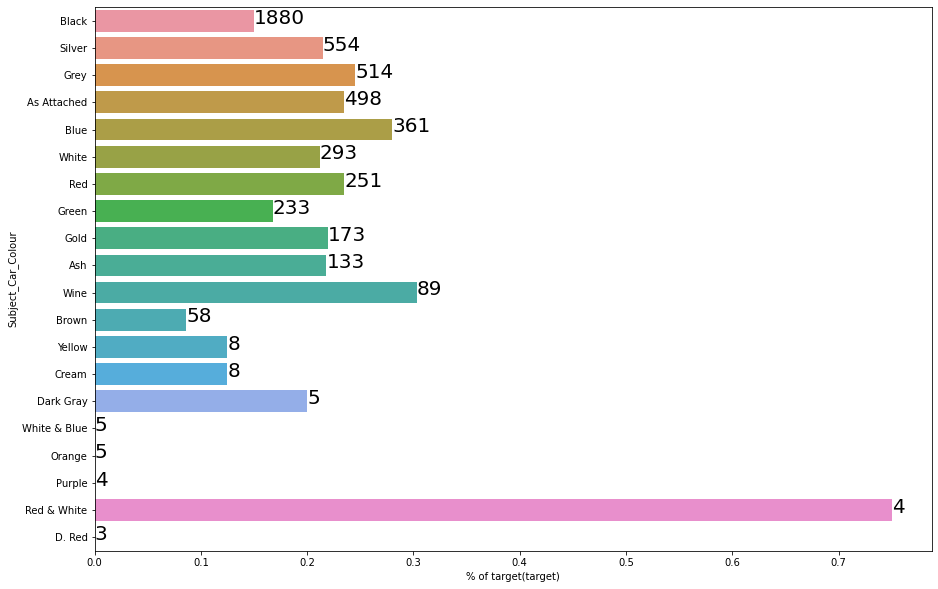

In [ ]:
col = cat_cols[2]
plot_category_percent_of_target(col)

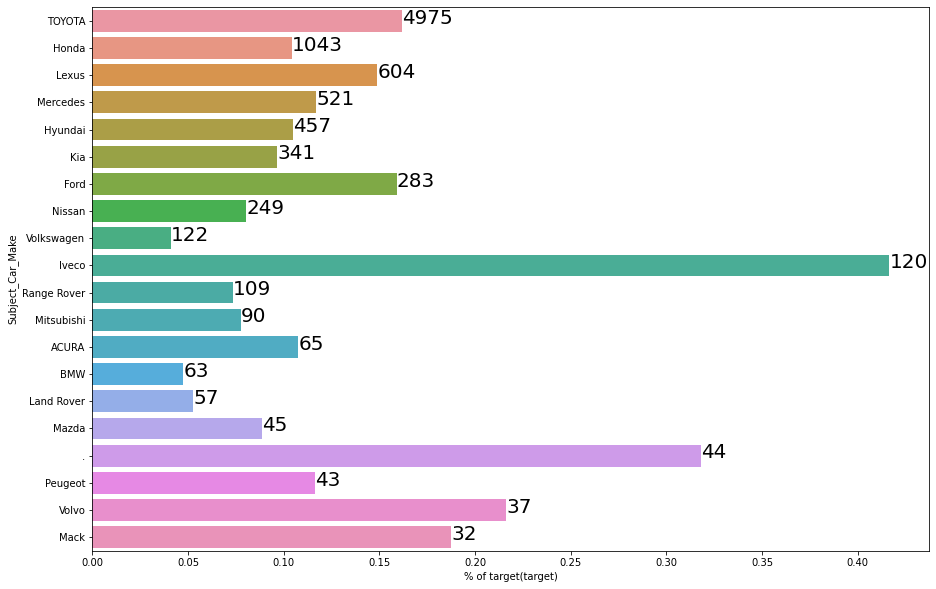

In [ ]:
col = cat_cols[3]
plot_category_percent_of_target(col)

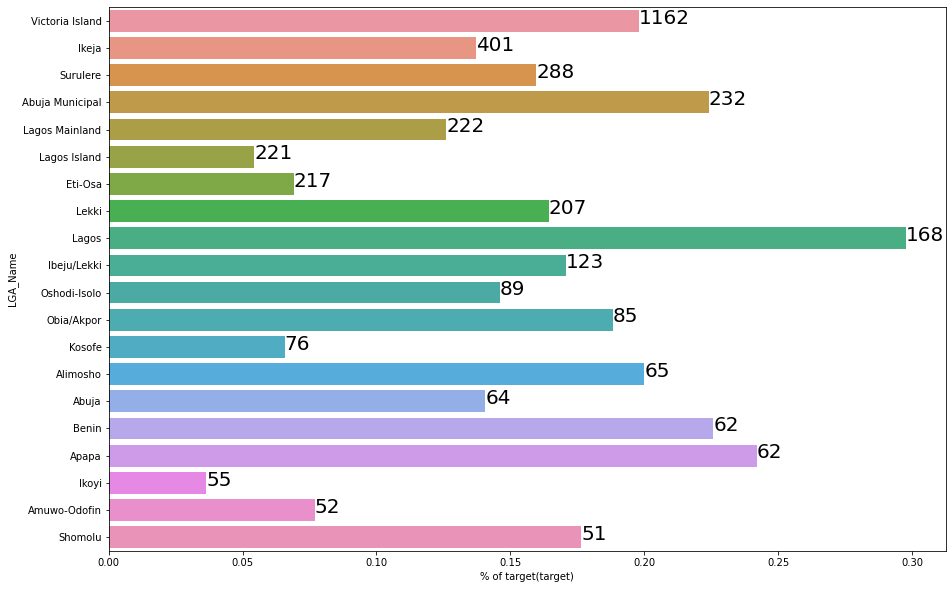

In [ ]:
col = cat_cols[4]
plot_category_percent_of_target(col)

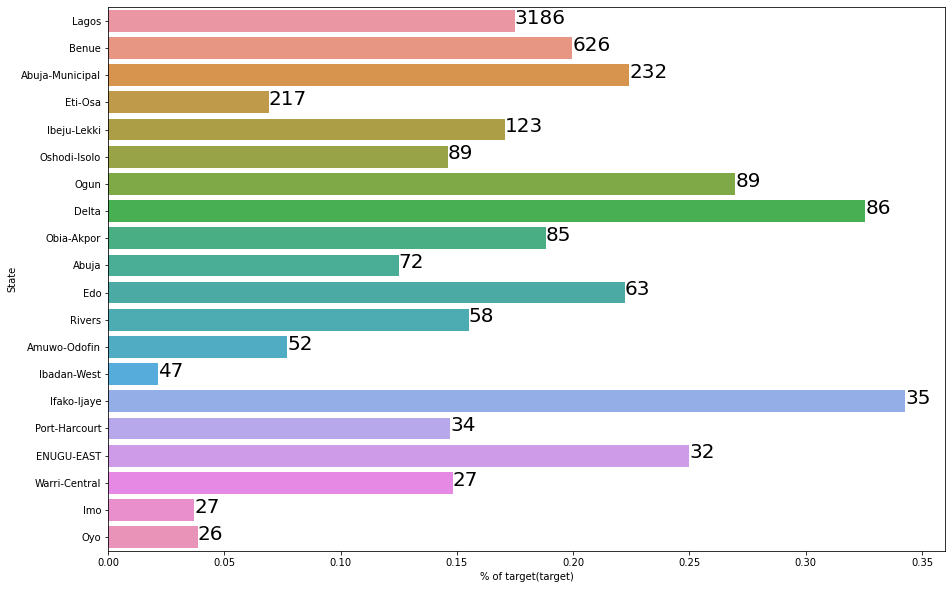

In [ ]:
col = cat_cols[5]
plot_category_percent_of_target(col)

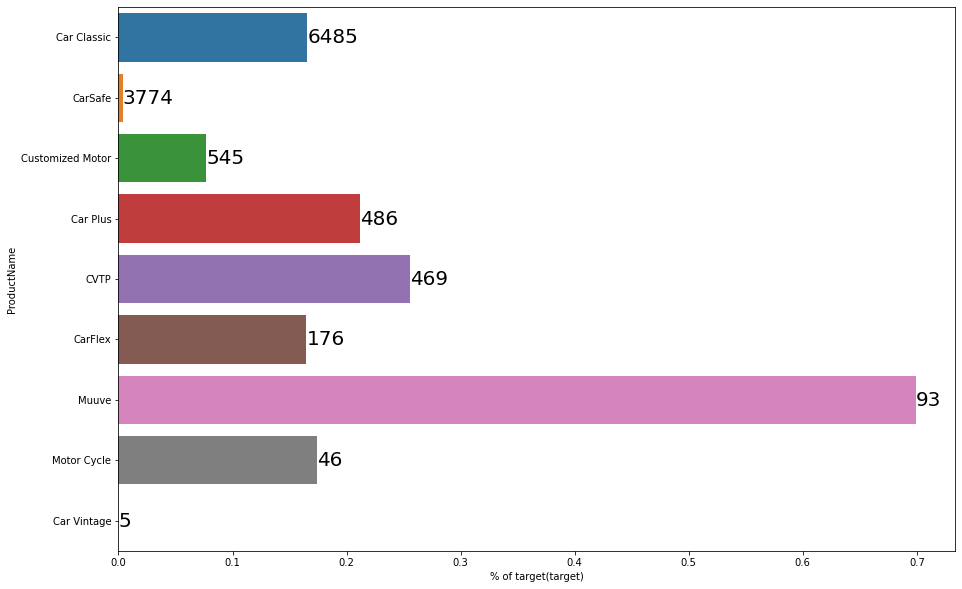

In [ ]:
col = cat_cols[6]
plot_category_percent_of_target(col)

In [ ]:
[var for var in train.columns if train[var].dtypes !='O']

['Age', 'No_Pol', 'target']

In [ ]:
no_cols = ['Age', 'No_Pol']

In [ ]:
def plot_category_percent_of_target_for_numeric(col):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    cat_percent = train[[col, 'target']].groupby(col, as_index=False).mean()
    cat_size = train[col].value_counts().reset_index(drop=False)
    cat_size.columns = [col, 'count']
    cat_percent = cat_percent.merge(cat_size, on=col, how='left')
    cat_percent['target'] = cat_percent['target'].fillna(0)
    cat_percent = cat_percent.sort_values(by='count', ascending=False)[:20]
    cat_percent[col] = cat_percent[col].astype('category')
    sns.barplot(ax=ax[0], x='target', y=col, data=cat_percent,  order=cat_percent[col])

    for i, p in enumerate(ax[0].patches):
        ax[0].annotate('{}'.format(cat_percent['count'].values[i]), (p.get_width(), p.get_y()+0.5), fontsize=20)

    ax[0].set_title('Barplot sorted by count', fontsize=20)

    sns.barplot(ax=ax[1], x='target', y=col, data=cat_percent)
    for i, p in enumerate(ax[0].patches):
        ax[1].annotate('{}'.format(cat_percent['count'].sort_index().values[i]), (0, p.get_y()+0.6), fontsize=20)
    ax[1].set_title('Barplot sorted by index', fontsize=20)

    plt.xlabel('% of target(target)')
    plt.ylabel(col)
    plt.subplots_adjust(wspace=0.5, hspace=0)
    plt.show()

def plot_kde_hist_for_numeric(col):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    sns.kdeplot(train.loc[train['target'] == 0, col], ax=ax[0], label='NoDetection(0)')
    sns.kdeplot(train.loc[train['target'] == 1, col], ax=ax[0], label='HasDetection(1)')

    train.loc[train['target'] == 0, col].hist(ax=ax[1], bins=100)
    train.loc[train['target'] == 1, col].hist(ax=ax[1], bins=100)

    plt.suptitle(col, fontsize=30)
    ax[0].set_yscale('log')
    ax[0].set_title('KDE plot')
    
    ax[1].set_title('Histogram')
    ax[1].legend(['NoDetection(0)', 'HasDetection(1)'])
    ax[1].set_yscale('log')
    plt.show()

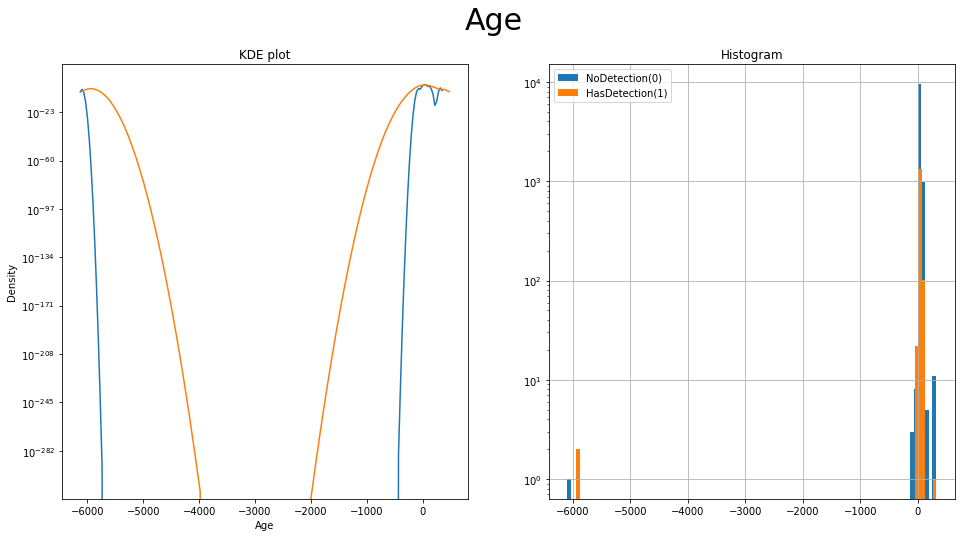

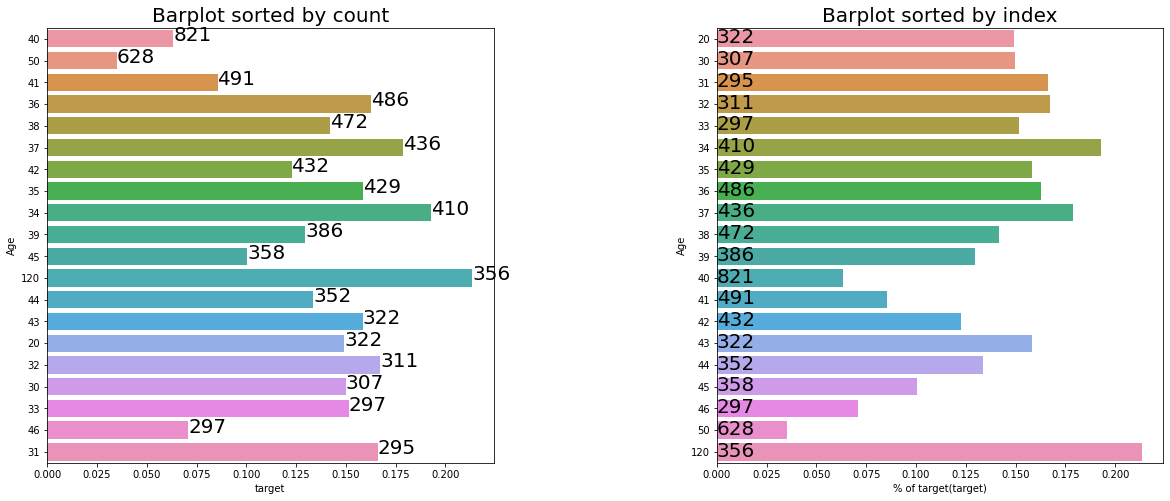

In [ ]:
col = no_cols[0]

plot_kde_hist_for_numeric(col)
plot_category_percent_of_target_for_numeric(col)

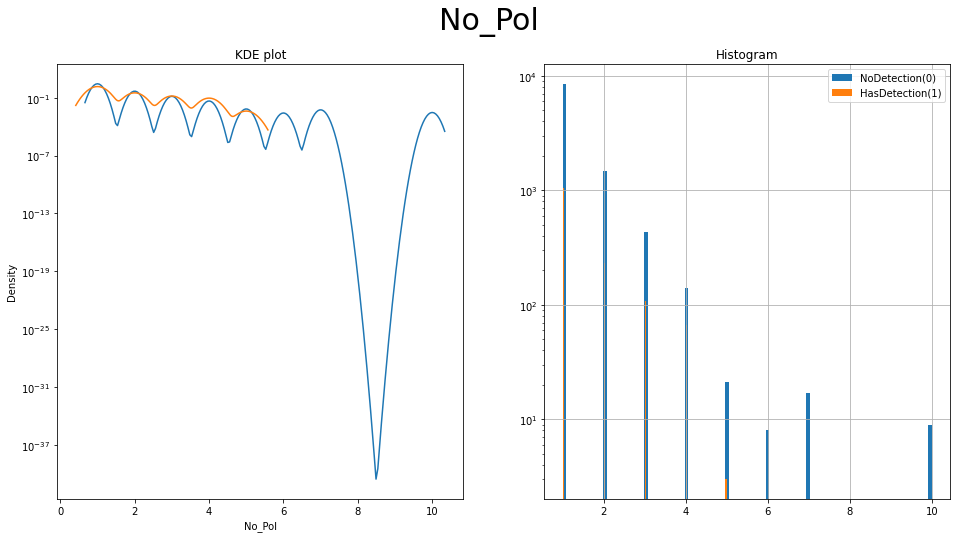

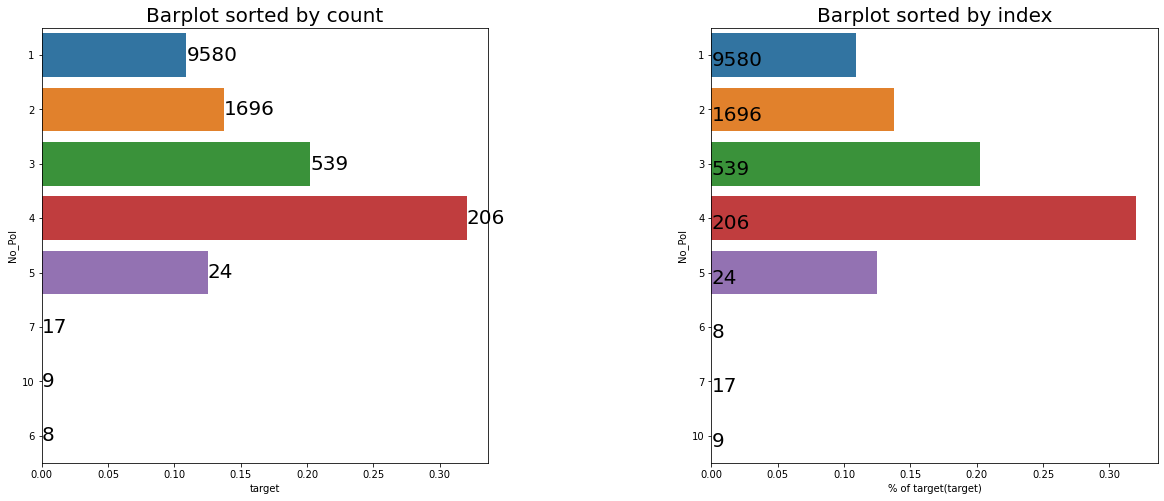

In [ ]:
col = no_cols[1]

plot_kde_hist_for_numeric(col)
plot_category_percent_of_target_for_numeric(col)

In [ ]:
corr = train.corr()['target']

In [ ]:
abs(corr).sort_values(ascending=False)

target    1.000000
No_Pol    0.074245
Age       0.028937
Name: target, dtype: float64

In [ ]:
tr = train.drop('target', axis = 1)

In [ ]:
%%time
features = tr.columns.values
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 45.1 ms, sys: 1.07 ms, total: 46.1 ms
Wall time: 47.1 ms


In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,6,3,12,7,9,11,8,10,4,1,5,2,0
Feature,No_Pol,Gender,ProductName,Car_Category,Subject_Car_Make,State,Subject_Car_Colour,LGA_Name,Age,Policy Start Date,First Transaction Date,Policy End Date,ID
Max duplicates,972,739,657,599,491,308,177,122,79,12,12,11,1
Value,1,Male,Car Classic,Saloon,TOYOTA,Lagos,Black,Victoria Island,40,2010-07-02,2010-07-02,2011-06-27,ID_18GG600


In [ ]:
%%time
idx = features = tr.columns.values
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 188 ms, sys: 3.89 ms, total: 191 ms
Wall time: 196 ms


In [ ]:
train[train.columns].head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,sum,min,max,mean,std,skew,kurt,med
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0,31,1,30,15.5,20.506097,NaN,NaN,15.5
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1,80,1,79,40.0,55.154329,NaN,NaN,40.0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0,44,1,43,22.0,29.698485,NaN,NaN,22.0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0,3,1,2,1.5,0.707107,NaN,NaN,1.5
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1,23,3,20,11.5,12.020815,NaN,NaN,11.5


In [ ]:
test[test.columns[13:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,47,1,46,23.5,31.819805,NaN,NaN,23.5
1,33,1,32,16.5,21.920310,NaN,NaN,16.5
2,47,2,45,23.5,30.405592,NaN,NaN,23.5
3,59,1,58,29.5,40.305087,NaN,NaN,29.5
4,121,1,120,60.5,84.145707,NaN,NaN,60.5


In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

ValueError: ignored

<Figure size 432x288 with 0 Axes>

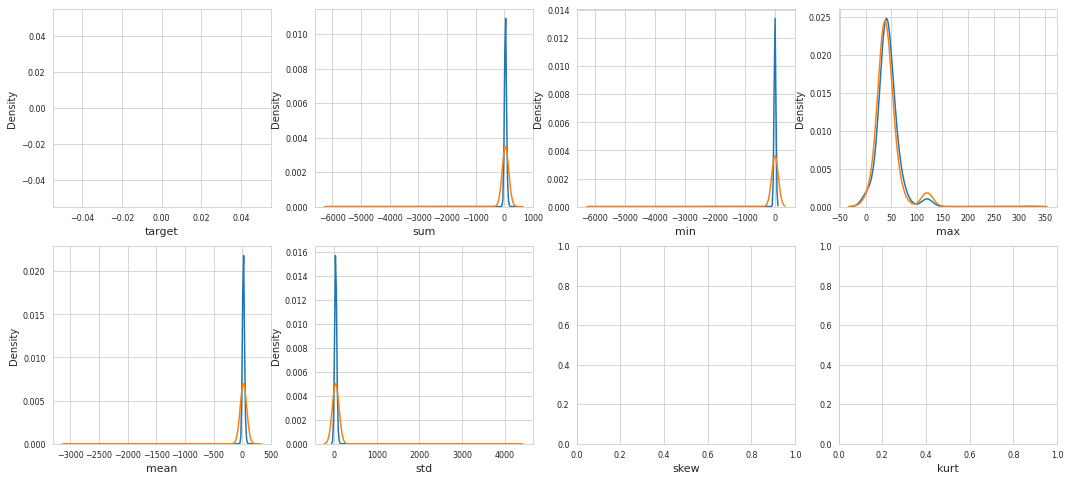

In [ ]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[13:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

<Figure size 432x288 with 0 Axes>

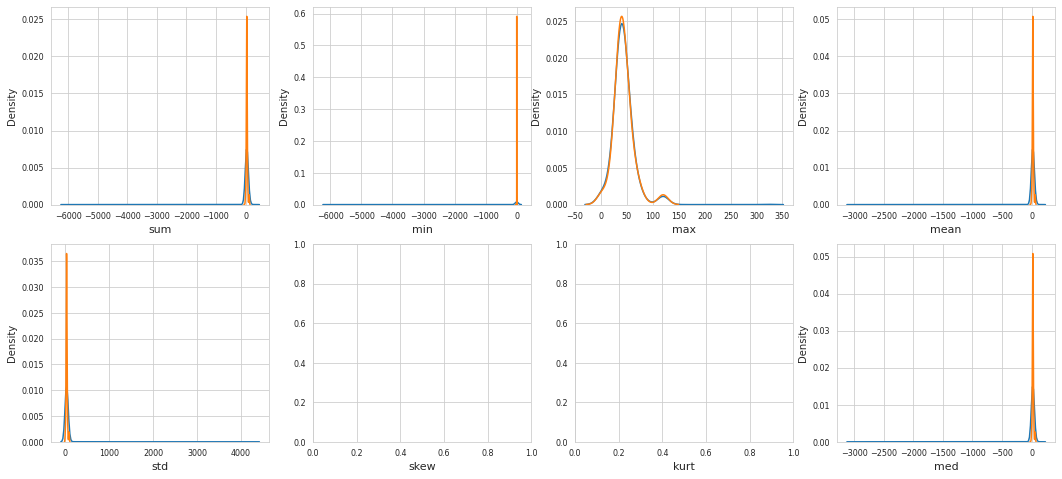

In [ ]:
features = tr.columns.values[13:]
plot_new_feature_distribution(tr, test, 'train', 'test', features)

In [ ]:
features = cont
for feature in features:
    train['r2_'+feature] = np.round(train[feature], 2)
    test['r2_'+feature] = np.round(test[feature], 2)
    train['r1_'+feature] = np.round(train[feature], 1)
    test['r1_'+feature] = np.round(test[feature], 1)

In [ ]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 42 41


In [ ]:
cont = ['Age',
 'No_Pol',
 'sum',
 'min',
 'max',
 'mean',
 'std',
 'skew',
 'kurt',
 'med']

**Policy Start Date**

In [ ]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'], format= '%Y-%m-%d')
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'], format= '%Y-%m-%d')

In [ ]:
train['day_start'] = train['Policy Start Date'].dt.day
test['day_start'] = test['Policy Start Date'].dt.day

train['dayofyear'] = train['Policy Start Date'].dt.dayofyear
train['dayofweek'] = train['Policy Start Date'].dt.dayofweek
train['weekofyear'] = train['Policy Start Date'].dt.weekofyear
#train['is_month_start'] = (train['Policy Start Date'].dt.is_month_start).astype(int)
#train['is_month_end'] = (train['Policy Start Date'].dt.is_month_end).astype(int)

#train['year_start'] = train['Policy Start Date'].dt.year
#test['year_start'] = test['Policy Start Date'].dt.year

#train['month_start'] = train['Policy Start Date'].dt.month
#test['month_start'] = test['Policy Start Date'].dt.month

train['weekday'] = train['Policy Start Date'].dt.weekday
test['weekday'] = test['Policy Start Date'].dt.weekday

test['dayofyear'] = test['Policy Start Date'].dt.dayofyear
test['dayofweek'] = test['Policy Start Date'].dt.dayofweek
test['weekofyear'] = test['Policy Start Date'].dt.weekofyear
#test['is_month_start'] = (test['Policy Start Date'].dt.is_month_start).astype(int)
#test['is_month_end'] = (test['Policy Start Date'].dt.is_month_end).astype(int)


train = train.drop('Policy Start Date', axis = 1)
test = test.drop('Policy Start Date', axis = 1)

**Policy End Date**

In [ ]:
train['Policy End Date'] = pd.to_datetime(train['Policy End Date'], format= '%Y-%m-%d')
test['Policy End Date'] = pd.to_datetime(test['Policy End Date'], format= '%Y-%m-%d')

In [ ]:
train['day_end'] = train['Policy End Date'].dt.day
test['day_end'] = test['Policy End Date'].dt.day

#train['year_end'] = train['Policy End Date'].dt.year
#test['year_end'] = test['Policy End Date'].dt.year

#train['quarter_end'] = train['Policy End Date'].dt.quarter
#test['quarter_end'] = test['Policy End Date'].dt.quarter

train['month_end'] = train['Policy End Date'].dt.month
test['month_end'] = test['Policy End Date'].dt.month

train['weekday'] = train['Policy End Date'].dt.weekday
test['weekday'] = test['Policy End Date'].dt.weekday

train = train.drop('Policy End Date', axis = 1)
test = test.drop('Policy End Date', axis = 1)

**Gender**

In [ ]:
target = train.target

In [ ]:
df_all = pd.concat([train.drop('target', axis=1), test], axis = 0)

In [ ]:
def gender(df):
    df['Gender'] = df['Gender'].map({'Male': 'M',
                                 'Female': 'F',
                                 'Entity': 'Unknown',
                                 'Joint Gender': 'Unknown',
                                 np.nan: 'Missing',
                                 'NOT STATED': 'Unknown',
                                 'NO GENDER': 'Unknown',
                                 'SEX': 'Unknown'})

In [ ]:
gender(df_all)

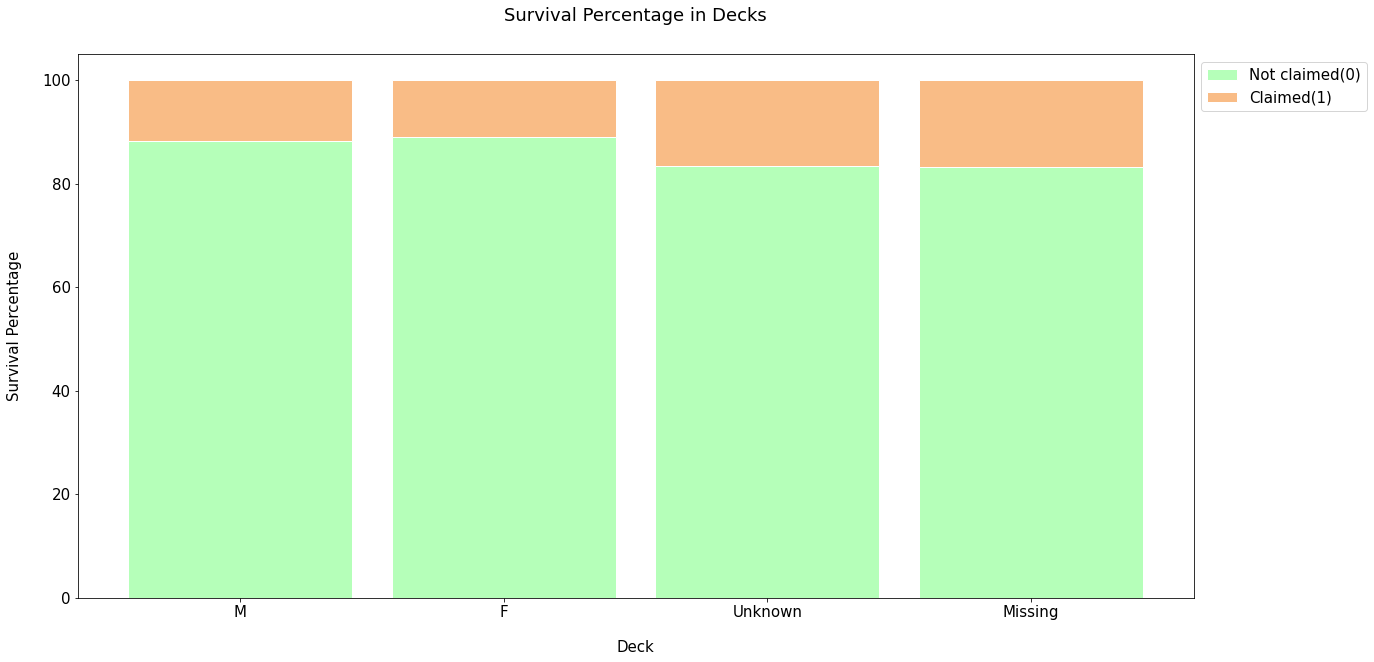

In [ ]:
df_all_decks_survived = df_all.groupby(['Gender', target]).count().drop(columns=['ID', 'Age', 'First Transaction Date', 'No_Pol', 'Car_Category', 
                                                                                   'Subject_Car_Colour', 'LGA_Name', 'State', 'ProductName']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'M':{}, 'F':{}, 'Unknown':{}, 'Missing':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('M', 'F', 'Unknown', 'Missing')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not claimed(0)")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Claimed(1)")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

***One hot encode Gender***

**Age**

In [ ]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

***Let's keep the Age as it is for now.***

**No_Pol**

In [ ]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'No_Pol']

**Car_Category**

In [ ]:
df_all.Car_Category.unique()

In [ ]:
def car_type(df):
    df['Car_Category'] = df['Car_Category'].map({'Saloon': 'Saloon',
                                                 'JEEP': 'JEEP',
                                                 'Motorcycle': 'Motorcycle',
                                                 'Truck': 'Truck',
                                                 'Bus': 'Bus',
                                                 'Mini Bus': 'Bus',
                                                 'Pick Up': 'Truck',
                                                 'Mini Van': 'Bus',
                                                 'Van': 'Bus',
                                                 'Pick Up > 3 Tons': 'Truck',
                                                 'CAMRY CAR HIRE': 'Sedan',
                                                 'Wagon': 'Other',
                                                 'Shape Of Vehicle Chasis': 'Other',
                                                 'Sedan': 'Sedan',
                                                 'Station 4 Wheel': 'Other',
                                                 'Tipper Truck': 'Truck',
                                                 np.nan: 'Missing'})

In [ ]:
car_type(df_all)

In [ ]:
df_all_decks_survived = df_all.groupby(['Car_Category', target]).count().drop(columns=['ID', 'Age', 'First Transaction Date', 'No_Pol', 'Gender', 
                                                                                   'Subject_Car_Colour', 'LGA_Name', 'State', 'ProductName']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'Sedan':{}, 'Unknown':{},'Motorcycle':{}, 'Truck': {}, 'Bus':{}, 'Other':{}, 'JEEP':{}, 'Saloon':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('Sedan', 'Unknown', 'Motorcycle', 'Truck', 'Bus', 'Other', 'JEEP', 'Saloon')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not claimed(0)")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Claimed(1)")
 
    plt.xlabel('Car_Category', size=15, labelpad=20)
    plt.ylabel('Claimed Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Claim Percentage in Car_Category', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

KeyError: ignored

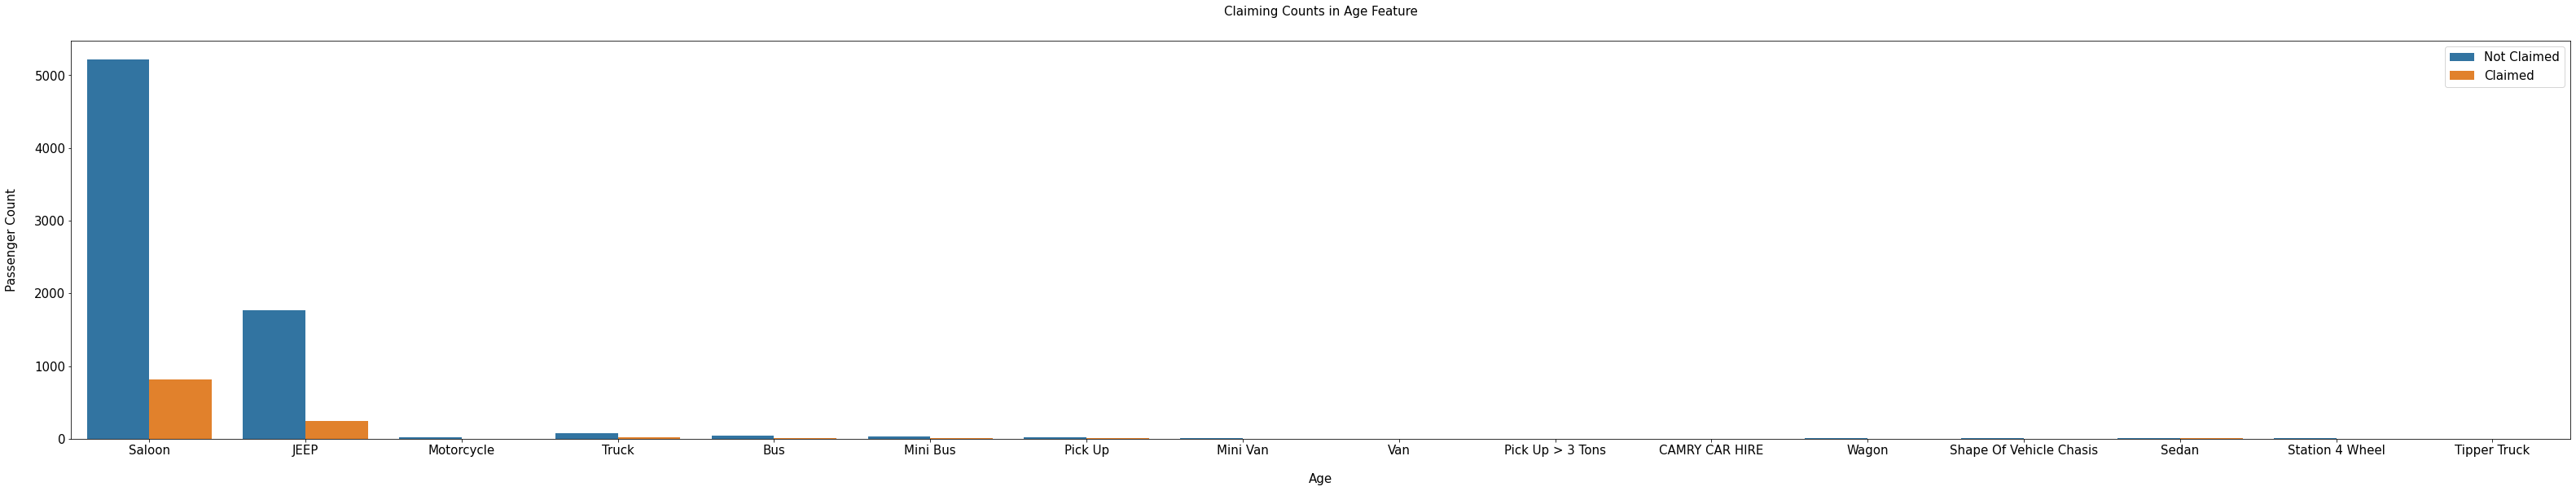

In [ ]:
fig, axs = plt.subplots(figsize=(55, 9))
sns.countplot(x='Car_Category', hue=target, data=train)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Claimed', 'Claimed'], loc='upper right', prop={'size': 15})
plt.title('Claiming Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [ ]:
df_all.head()

,ID,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,day_start,dayofyear,dayofweek,weekofyear,weekday,day_end,month_end
0,ID_0040R73,M,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,14,134,4,19,4,13,5
1,ID_0046BNK,F,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,29,333,0,48,0,28,11
2,ID_005QMC3,M,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,21,80,6,11,6,20,3
3,ID_0079OHW,M,2,2010-08-21,1,Missing,NaN,NaN,NaN,NaN,CarSafe,21,233,5,33,5,20,8
4,ID_00BRP63,Unknown,20,2010-08-29,3,Missing,NaN,NaN,Lagos,Lagos,Muuve,29,241,6,34,4,31,12


**Subject_Car_Colour**

In [ ]:
df_all.Subject_Car_Colour.unique()

array(['Black', 'Grey', 'Red', nan, 'As Attached', 'Blue', 'Silver',
       'Green', 'Ash', 'White', 'Gray & Gray', 'Wine', 'Brown',
       'Red & Blue', 'Gold', 'Gray & Silver', 'Orange', 'Red & Black',
       'Dark Grey', 'White & Red', 'Light Green', 'Dark Gray', 'B.Silver',
       'Purple', 'Blue & Red', 'Red & Yellow', 'Yellow', 'Red & White',
       'D. Red', 'Dark Red', 'Black & White', 'White & Blue', 'Cream',
       'Dark Green', 'D. Gold', 'Champagne', 'Light Blue',
       'Blue&White&Red', 'White & Yellow', 'Dark Blue', 'Black & Orange',
       'Burgundy', 'Yellow & White', 'Beige Mitalic', 'Light Gray',
       'Blue Sky', 'Red Maroon'], dtype=object)

In [ ]:
def car_color(df):
    df['Subject_Car_Colour'] = df['Subject_Car_Colour'].map({'Black': 'Black',
                                                             'Grey': 'Grey',
                                                             'Silver': 'Silver',
                                                             'Blue': 'Blue',
                                                             'Red': 'Red',
                                                             'As Attached': 'Other',
                                                             'Gold': 'Gold',
                                                             'Ash': 'Ash',
                                                             'White': 'White',
                                                             'Brown': 'Brown',
                                                             'B.Silver': 'Silver',
                                                             'Wine': 'Wine',
                                                             'Gray & Gray': 'Gray',
                                                             'Champagne': 'Champagne',
                                                             'D. Red': 'Dark Red',
                                                             'Dark Red': 'Dark Red',
                                                             'Black & White': 'Black & White',
                                                             'Red & White': 'Red & White',
                                                             'Light Gray': 'Light Gray',
                                                             'Cream': 'Cream',
                                                             'Dark Grey': 'Dark Grey',
                                                             'Dark Blue': 'Dark Blue',
                                                             'Yellow': 'Yellow',
                                                             'Light Green': 'Light Green',
                                                             'Red & Black': 'Red & Black',
                                                             'Purple': 'Purple',
                                                             'D. Gold': ' Dark Gold',
                                                             'Blue & Red': 'Blue & Red',
                                                             'Orange': 'Orange',
                                                             'Blue&White&Red': 'Blue&White&Red',
                                                             'Burgundy': 'Burgundy',
                                                             'Gray & Silver': 'Gray & Silver',
                                                             'White & Blue': 'White & Blue',
                                                             'Beige Mitalic': 'Beige Mitalic',
                                                             'Black & Orange': 'Black & Orange',
                                                             'Red & Yellow': 'Red & Yellow',
                                                             'Dark Gray': 'Dark Grey',
                                                             'Green': 'Green',
                                                             'Red & Blue': 'Blue & Red',
                                                             'White & Red': 'White & Red',
                                                             'Dark Green': 'Dark Green',
                                                             'Light Blue': 'Light Blue',
                                                             'White & Yellow': 'White & Yellow',
                                                             'Yellow & White': 'White & Yellow',
                                                             'Blue Sky': 'Blue Sky',
                                                             'Red Maroon': 'Red Maroon',
                                                             np.nan: 'Missing'})

In [ ]:
car_color(df_all)

In [ ]:
#df_all['color_freq'] = df_all.groupby('Subject_Car_Colour')['Subject_Car_Colour'].transform('count')

**Subject_Car_Make**

In [ ]:

def car_company(df):
    df['Subject_Car_Make'] = df['Subject_Car_Make'].map({'TOYOTA': 'TOYOTA',
                                                         'REXTON': 'REXTON',
                                                         'Lexus': 'Lexus',
                                                         'Hyundai': 'Hyundai',
                                                         'Iveco': 'Iveco',
                                                         'DAF': 'DAF',
                                                         'Honda': 'Honda',
                                                         'Mercedes': 'Mercedes',
                                                         'Jincheng': 'Jincheng',
                                                         'ACURA': 'ACURA',
                                                         'Ford': 'Ford',
                                                         'Volkswagen': 'Volkswagen',
                                                         'Nissan': 'Nissan',
                                                         '.': 'Other',
                                                         'Pontiac': 'Pontiac',
                                                         'Range Rover': 'Range Rover',
                                                         'Kia': 'Kia',
                                                         'Mitsubishi': 'Mitsubishi',
                                                         'Scania': 'Scania',
                                                         'BMW': 'BMW',
                                                         'Infiniti': 'Infiniti',
                                                         'Renault': 'Renault',
                                                         'Volvo': 'Volvo',
                                                         'Hummer': 'Hummer',
                                                         'Mack': 'Mack',
                                                         'Grand Cherokee': 'Jeep',
                                                         'Porsche': 'Porsche',
                                                         'Peugeot': 'Peugeot',
                                                         'Land Rover': 'Land Rover',
                                                         'Chevrolet': 'Chevrolet',
                                                         'Mazda': 'Mazda',
                                                         'Man': 'Man',
                                                         'Jeep': 'Jeep',
                                                         'Audi': 'Audi',
                                                         'Suzuki': 'Suzuki',
                                                         'MINI COOPER': 'MINI COOPER',
                                                         'KA': 'Ford',
                                                         'As Attached': 'Other',
                                                         'Innson': 'Innson',
                                                         'Isuzu': 'Isuzu',
                                                         'Skoda': 'Skoda',
                                                         'Jaguar': 'Jaguar',
                                                         'Chrysler': 'Chrysler',
                                                         'Dodge': 'Dodge',
                                                         'GMC': 'GMC',
                                                         'Land Rover.': 'Land Rover',
                                                         'Subaru': 'Subaru',
                                                         'GAC': 'GAC',
                                                         'Fiat': 'Fiat',
                                                         'Opel': 'Opel',
                                                         'Astra': 'Astra',
                                                         'Motorcycle': 'Motorcycle',
                                                         'ZOYTE': 'ZOYTE',
                                                         'Seat': 'Seat',
                                                         'FOTON': 'FOTON',
                                                         'Howo': 'Howo',
                                                         'Lincoln': 'Lincoln',
                                                         'Rols Royce': 'Rolls Royce',
                                                         'CHANGAN': 'CHANGAN',
                                                         'LIBERTY': 'LIBERTY',
                                                         'ABG': 'ABG',
                                                         'Yamaha': 'Yamaha',
                                                         'Black': 'Other',
                                                         'Tata': 'Tata',
                                                         'Ashok Leyland': 'Ashok Leyland',
                                                         'Geely': 'Geely',
                                                         'Caddillac': 'Caddillac',
                                                         'Wrangler Jeep': 'Jeep',
                                                         'Raston': 'Ralston',
                                                         'MG': 'MG',
                                                         'BRILLIANCE': 'BRILLIANCE',
                                                         'Buik': 'Buik',
                                                         'COMMANDER': 'Jeep',
                                                         'Bajaj': 'Bajaj',
                                                         'Datsun': 'Datsun',
                                                         np.nan: 'Missing'})

In [ ]:
car_company(df_all)

In [ ]:
#car = df_all.Subject_Car_Make.value_counts()
#mapping = df_all.Subject_Car_Make.map(car)
#df_all['Subject_Car_Make'] = df_all['Subject_Car_Make'].mask(mapping < 6, 'Other')

In [ ]:
#df_all['maker_freq'] = df_all.groupby('Subject_Car_Make')['Subject_Car_Make'].transform('count')

**LGA_Name**

In [ ]:
df_all.LGA_Name.fillna('Unknown', inplace = True, axis = 0) 

In [ ]:
#lga_freq = df_all.LGA_Name.value_counts()
#mapping = df_all.LGA_Name.map(lga_freq)
#df_all['LGA_Name'] = df_all['LGA_Name'].mask(mapping <= 3, 'Other')

In [ ]:

#df_all['lga_freq'] = df_all.groupby('LGA_Name')['LGA_Name'].transform('count')

**State**

In [ ]:
df_all.State.fillna('Unknown', inplace = True, axis = 0)

In [ ]:
#state_freq = df_all.State.value_counts()
#mapping = df_all.State.map(state_freq)
#df_all['State'] = df_all['State'].mask(mapping <= 3, 'Other')

In [ ]:
#df_all['state_freq'] = df_all.groupby('State')['State'].transform('count')

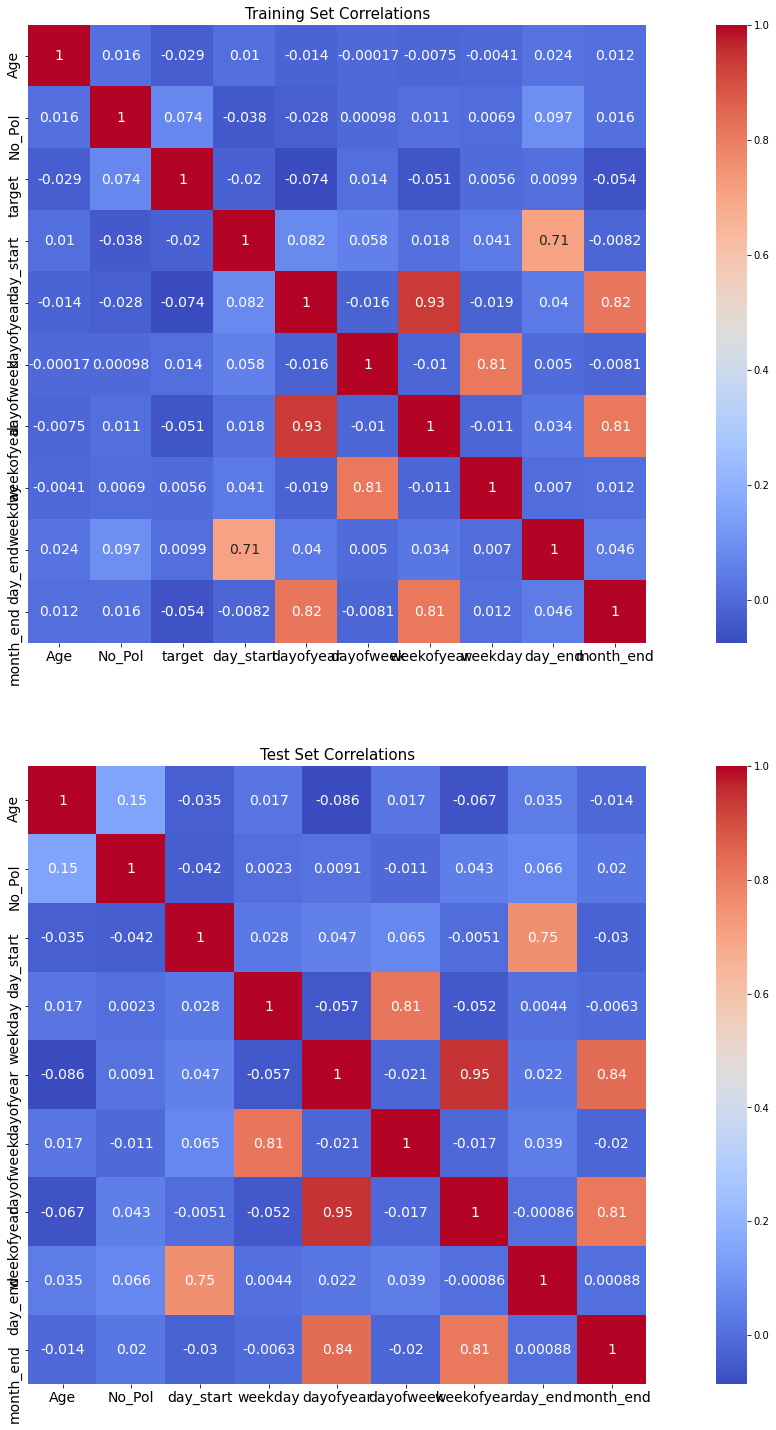

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(25, 25))

sns.heatmap(train.drop(['ID'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(test.drop(['ID'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

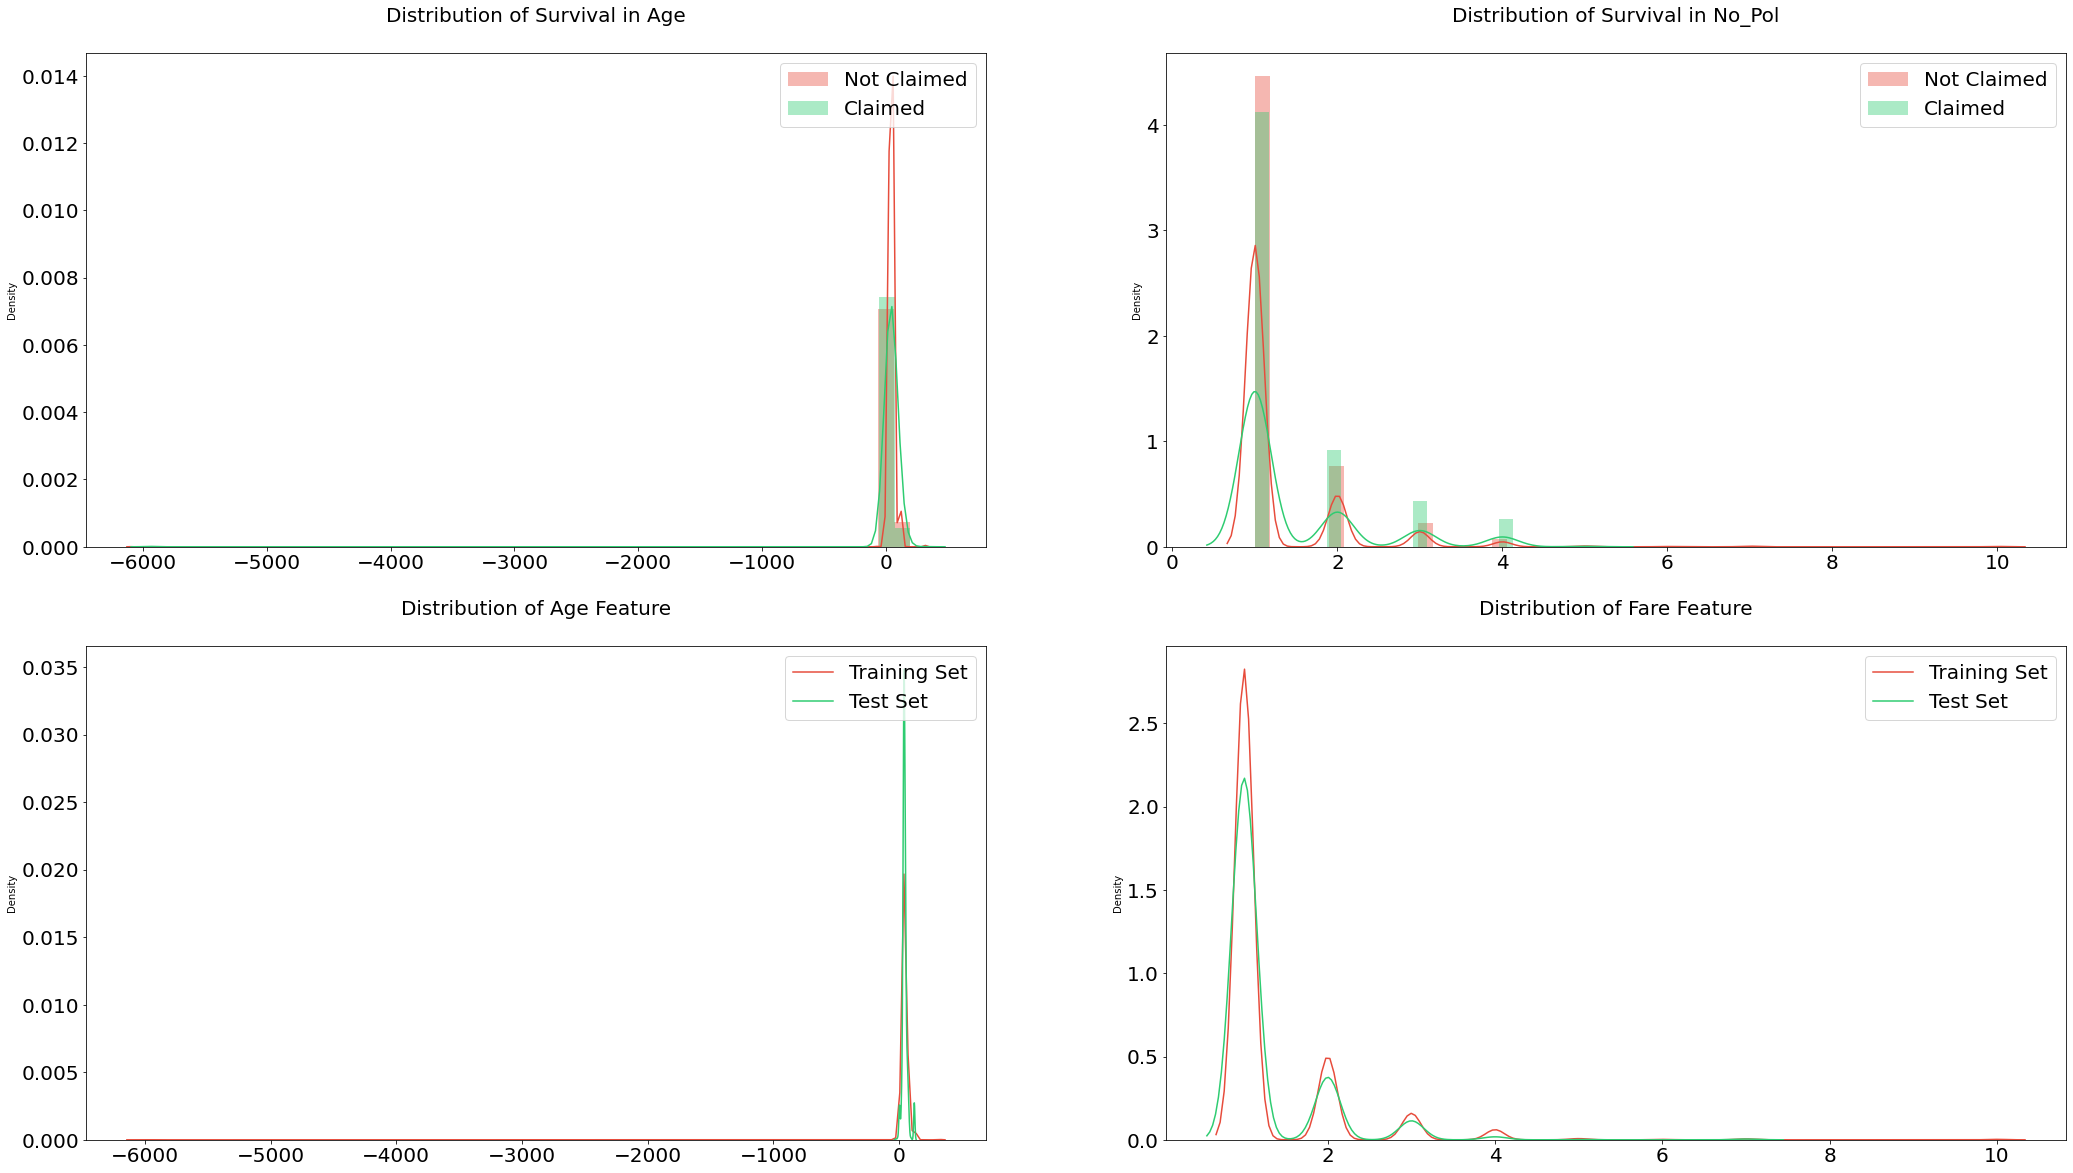

In [ ]:

cont_features = ['Age', 'No_Pol']
surv = train['target'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(train[~surv][feature], label='Not Claimed', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(train[surv][feature], label='Claimed', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

In [ ]:
[var for var in train.columns if train[var].dtypes == 'O']

['ID',
 'Gender',
 'First Transaction Date',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

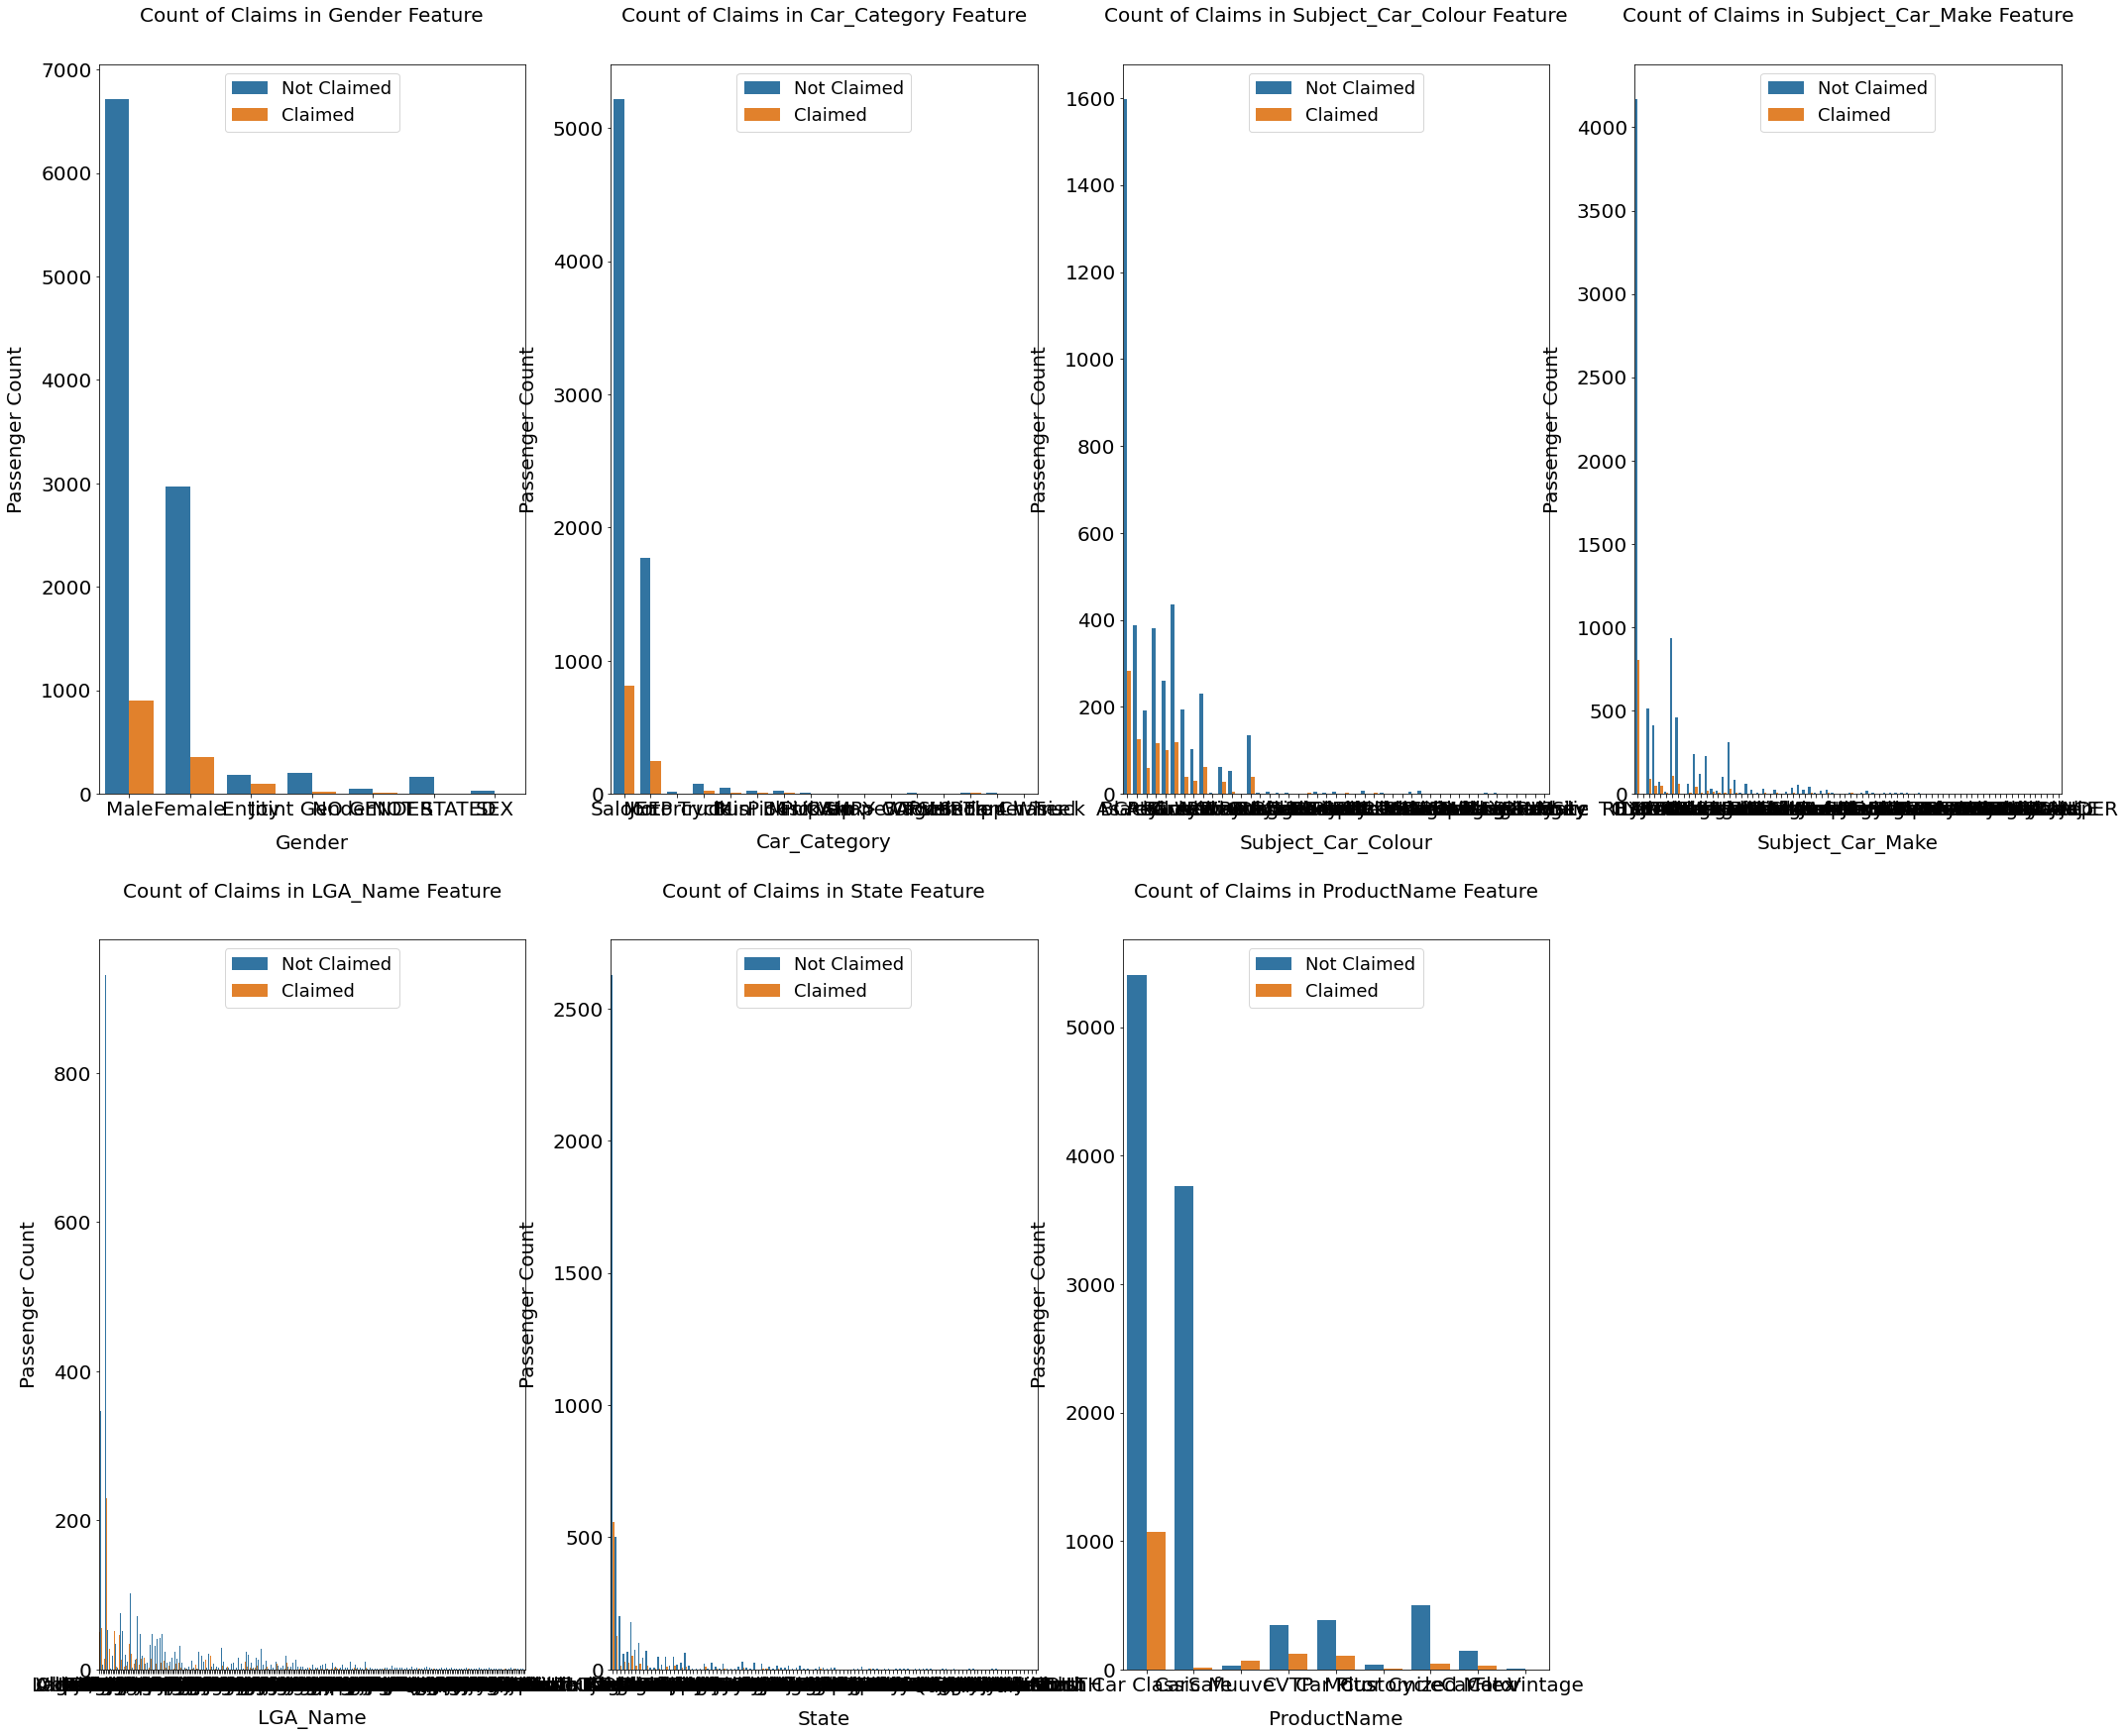

In [ ]:

cat_features = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, hue='target', data=train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Claimed', 'Claimed'], loc='upper center', prop={'size': 18})
    plt.title('Count of Claims in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

In [ ]:
#df_all['age_bins']= pd.qcut(df_all.Age, q=10, labels=False)

In [ ]:
df_all['prod_age_cnt'] = df_all.groupby(['ProductName'])['Age'].transform('count')
df_all['prod_age_mean'] = df_all.groupby(['ProductName'])['Age'].transform('mean')
df_all['prod_age_max'] = df_all.groupby(['ProductName'])['Age'].transform('max')
df_all['prod_age_min'] = df_all.groupby(['ProductName'])['Age'].transform('min')
df_all['prod_age_sum'] = df_all.groupby(['ProductName'])['Age'].transform('sum')


#df_all['prod_doy_mean'] = df_all.groupby(['ProductName'])['dayofyear'].transform('mean')
#df_all['prod_doy_std'] = df_all.groupby(['ProductName'])['dayofyear'].transform('std')
#df_all['prod_doy_min'] = df_all.groupby(['ProductName'])['dayofyear'].transform('min')
#df_all['prod_doy_cnt'] = df_all.groupby(['ProductName'])['dayofyear'].transform('count')


#df_all['lga_doy_cnt'] = df_all.groupby(['LGA_Name'])['dayofyear'].transform('count')
#df_all['lga_doy_mean'] = df_all.groupby(['LGA_Name'])['dayofyear'].transform('mean')
#df_all['lga_doy_max'] = df_all.groupby(['LGA_Name'])['dayofyear'].transform('max')
#df_all['lga_doy_min'] = df_all.groupby(['LGA_Name'])['dayofyear'].transform('min')
#df_all['lga_doy_sum'] = df_all.groupby(['LGA_Name'])['dayofyear'].transform('sum')


df_all['lga_age_cnt'] = df_all.groupby(['LGA_Name'])['Age'].transform('count')
df_all['lga_age_mean'] = df_all.groupby(['LGA_Name'])['Age'].transform('mean')
df_all['lga_age_max'] = df_all.groupby(['LGA_Name'])['Age'].transform('max')
df_all['lga_age_min'] = df_all.groupby(['LGA_Name'])['Age'].transform('min')
df_all['lga_age_sum'] = df_all.groupby(['LGA_Name'])['Age'].transform('sum')


df_all['make_age_cnt'] = df_all.groupby(['Subject_Car_Make'])['Age'].transform('count')
df_all['make_age_mean'] = df_all.groupby(['Subject_Car_Make'])['Age'].transform('mean')
df_all['make_age_max'] = df_all.groupby(['Subject_Car_Make'])['Age'].transform('max')
df_all['make_age_min'] = df_all.groupby(['Subject_Car_Make'])['Age'].transform('min')
df_all['make_age_sum'] = df_all.groupby(['Subject_Car_Make'])['Age'].transform('sum')

In [ ]:
train.No_Pol.unique()

array([ 1,  3,  2,  4,  5,  7, 10,  6])

In [ ]:
10/10

1.0

In [ ]:
df_all['No_Pol'] = df_all['No_Pol'].map({1:0.1, 2:0.2, 3:0.3, 4:0.4, 5:0.5, 6:0.6, 7:0.7, 10:1.0})

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()

#for col in ['No_Pol']:
#    df_all[col]=  df_all[col].astype('str')
#    df_all[col]= le.fit_transform(df_all[col])

In [ ]:
df_all['prod_age'] = df_all.ProductName.astype(str) + '_' + df_all.Age.astype(str)
df_all['lga_age'] = df_all.LGA_Name.astype(str) + '_' + df_all.Age.astype(str)
df_all['make_age'] = df_all.Subject_Car_Make.astype(str) + '_' + df_all.Age.astype(str)
df_all['color_age'] = df_all.Subject_Car_Colour.astype(str) + '_' + df_all.Age.astype(str)
df_all['lga_prod'] = df_all.LGA_Name.astype(str) + '_' + df_all.ProductName.astype(str)
df_all['make_prod'] = df_all.Subject_Car_Make.astype(str) + '_' + df_all.ProductName.astype(str)
df_all['prod_age_lga'] = df_all.prod_age.astype(str) + '_' + df_all.lga_age.astype(str)

In [ ]:
win = Winsorizer(capping_method='iqr', tail='both', variables=['Age'], fold=1.5)

In [ ]:
win.fit(df_all)
df_all =win.transform(df_all)

In [ ]:
#print(df_all['Age'].quantile(0.50)) 
#print(df_all['Age'].quantile(0.95))
#print(df_all['Age'].quantile(0.04))
#df_all['Age'] = np.where(df_all['Age'] > 86, 41, df_all['Age'])
#df_all['Age'] = np.where(df_all['Age'] < 0, 41, df_all['Age'])
#df_all.describe()
##df_all['Age'] = pd.qcut(df_all['Age'], 15, labels=False)

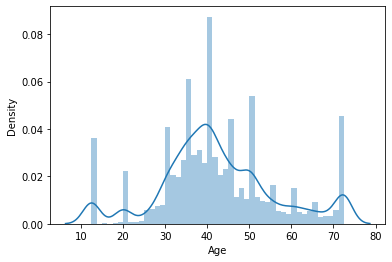

In [ ]:
sns.distplot(df_all.Age)

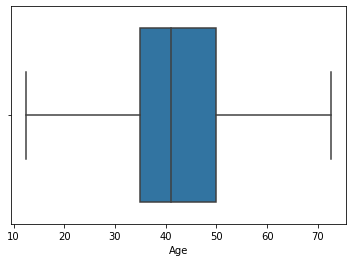

In [ ]:
sns.boxplot((df_all.Age))

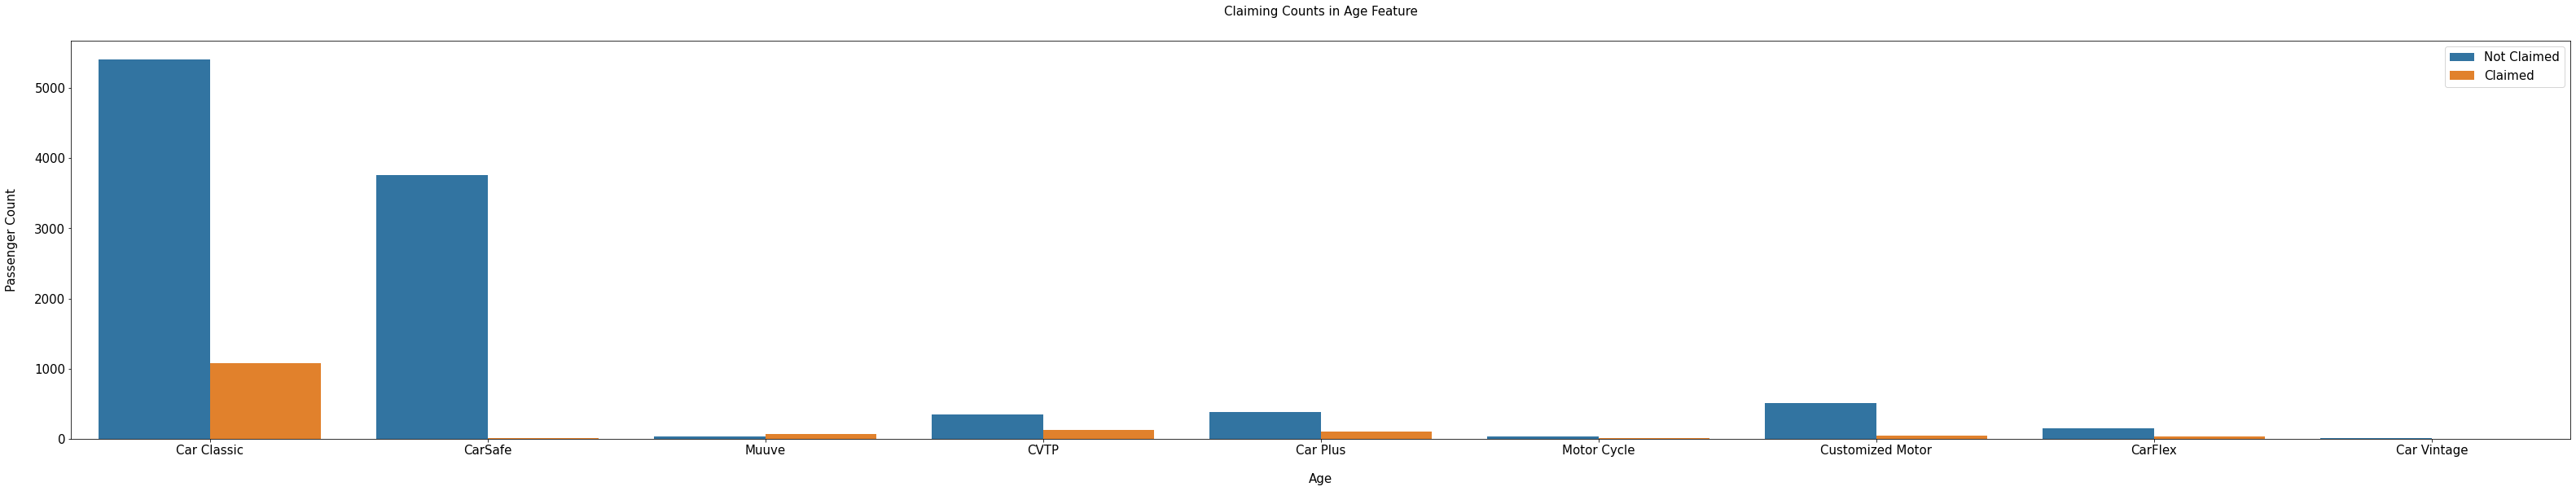

In [ ]:
fig, axs = plt.subplots(figsize=(55, 9))
sns.countplot(x='ProductName', hue=target, data=train)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Claimed', 'Claimed'], loc='upper right', prop={'size': 15})
plt.title('Claiming Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [ ]:
[var for var in df_all.columns if df_all[var].dtypes == 'O']

['ID',
 'Gender',
 'First Transaction Date',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [ ]:
#pol = pd.get_dummies(df_all.No_Pol, prefix='pol_', drop_first=True)
#df_all = pd.concat([df_all, pol], axis = 1)

In [ ]:
train = df_all[:12079]
test = df_all[12079:]

In [ ]:
train['date_age'] = train['First Transaction Date'].astype(str) + '_' + train.Age.astype(str)
train['date_lga'] = train['First Transaction Date'].astype(str) + '_' + train.LGA_Name.astype(str)
train['date_make'] = train['First Transaction Date'].astype(str) + '_' + train.Subject_Car_Make.astype(str)
train['date_color'] = train['First Transaction Date'].astype(str) + '_' + train.Subject_Car_Colour.astype(str)
train['date_prod'] = train['First Transaction Date'].astype(str) + '_' + train.ProductName.astype(str)
train['date_day_start'] = train['First Transaction Date'].astype(str) + '_' + train.day_start.astype(str)
train['date_month_end'] = train['First Transaction Date'].astype(str) + '_' + train.month_end.astype(str)

train['lga_age'] = train.LGA_Name.astype(str) + '_' + train.Age.astype(str)
train['lga_make'] = train.LGA_Name.astype(str) + '_' + train.Subject_Car_Make.astype(str)


train['make_color'] = train.Subject_Car_Make.astype(str) + '_' + train.Subject_Car_Colour.astype(str)
train['make_prod'] = train.Subject_Car_Make.astype(str) + '_' + train.ProductName.astype(str)
train['make_day_start'] = train.Subject_Car_Make.astype(str) + '_' + train.day_start.astype(str)

train['product_day_start'] = train.ProductName.astype(str) + '_' + train.day_start.astype(str)
train['prod_lga'] = train.ProductName.astype(str) + '_' + train.LGA_Name.astype(str)

In [ ]:
test['date_age'] = test['First Transaction Date'].astype(str) + '_' + test.Age.astype(str)
test['date_lga'] = test['First Transaction Date'].astype(str) + '_' + test.LGA_Name.astype(str)
test['date_make'] = test['First Transaction Date'].astype(str) + '_' + test.Subject_Car_Make.astype(str)
test['date_color'] = test['First Transaction Date'].astype(str) + '_' + test.Subject_Car_Colour.astype(str)
test['date_prod'] = test['First Transaction Date'].astype(str) + '_' + test.ProductName.astype(str)
test['date_day_start'] = test['First Transaction Date'].astype(str) + '_' + test.day_start.astype(str)
test['date_month_end'] = test['First Transaction Date'].astype(str) + '_' + test.month_end.astype(str)

test['lga_age'] = test.LGA_Name.astype(str) + '_' + test.Age.astype(str)
test['lga_make'] = test.LGA_Name.astype(str) + '_' + test.Subject_Car_Make.astype(str)


test['make_color'] = test.Subject_Car_Make.astype(str) + '_' + test.Subject_Car_Colour.astype(str)
test['make_prod'] = test.Subject_Car_Make.astype(str) + '_' + test.ProductName.astype(str)
test['make_day_start'] = test.Subject_Car_Make.astype(str) + '_' + test.day_start.astype(str)

test['product_day_start'] = test.ProductName.astype(str) + '_' + test.day_start.astype(str)
test['prod_lga'] = test.ProductName.astype(str) + '_' + test.LGA_Name.astype(str)

In [ ]:
'''columns=['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

comb = combinations(columns,2)
for i in list(comb):
    train[f'{i[0]}_{i[1]}']=train[i[0]].astype(str)+'_'+train[i[1]].astype(str)
    test[f'{i[0]}_{i[1]}']=test[i[0]].astype(str)+'_'+test[i[1]].astype(str)'''

"columns=['Gender',\n 'Car_Category',\n 'Subject_Car_Colour',\n 'Subject_Car_Make',\n 'LGA_Name',\n 'State',\n 'ProductName']\n\ncomb = combinations(columns,2)\nfor i in list(comb):\n    train[f'{i[0]}_{i[1]}']=train[i[0]].astype(str)+'_'+train[i[1]].astype(str)\n    test[f'{i[0]}_{i[1]}']=test[i[0]].astype(str)+'_'+test[i[1]].astype(str)"

In [ ]:
'''train['lga_prod'] = train.LGA_Name.astype(str) + '_' + train.ProductName.astype(str)
train['lga_age'] = train.LGA_Name.astype(str) + '_' + train.Age.astype(str)
train['lga_maker'] = train.LGA_Name.astype(str) + '_' + train.Subject_Car_Make.astype(str)
train['lga_color'] = train.LGA_Name.astype(str) + '_' + train.Subject_Car_Colour.astype(str)
#train['lga_state'] = train.LGA_Name.astype(str) + '_' + train.State.astype(str)
train['lga_date'] = train.LGA_Name.astype(str) + '_' + train['First Transaction Date'].astype(str)

train['prod_age'] = train.ProductName.astype(str) + '_' + train.Age.astype(str)
train['prod_make'] = train.ProductName.astype(str) + '_' + train.Subject_Car_Make.astype(str)
train['prod_color'] = train.ProductName.astype(str) + '_' + train.Subject_Car_Colour.astype(str)
train['prod_date'] = train.ProductName.astype(str) + '_' + train['First Transaction Date'].astype(str)
train['prod_state'] = train.ProductName.astype(str) + '_' + train.State.astype(str)

train['date_state'] = train['First Transaction Date'].astype(str) + '_' + train.State.astype(str)
train['date_age'] = train['First Transaction Date'].astype(str) + '_' + train.Age.astype(str)
train['date_maker'] = train['First Transaction Date'].astype(str) + '_' + train.Subject_Car_Make.astype(str)
train['date_color'] = train['First Transaction Date'].astype(str) + '_' + train.Subject_Car_Colour.astype(str)

train['color_age'] = train.Subject_Car_Colour.astype(str) + '_' + train.Age.astype(str)
train['color_state'] = train.Subject_Car_Colour.astype(str) + '_' + train.State.astype(str)
train['color_make'] = train.Subject_Car_Colour.astype(str) + '_' + train.Subject_Car_Make.astype(str)

train['make_state'] = train.Subject_Car_Make.astype(str) + '_' + train.State.astype(str)'''

In [ ]:
'''test['lga_prod'] = test.LGA_Name.astype(str) + '_' + test.ProductName.astype(str)
test['lga_age'] = test.LGA_Name.astype(str) + '_' + test.Age.astype(str)
test['lga_maker'] = test.LGA_Name.astype(str) + '_' + test.Subject_Car_Make.astype(str)
test['lga_color'] = test.LGA_Name.astype(str) + '_' + test.Subject_Car_Colour.astype(str)
#test['lga_state'] = test.LGA_Name.astype(str) + '_' + test.State.astype(str)
test['lga_date'] = test.LGA_Name.astype(str) + '_' + test['First Transaction Date'].astype(str)

test['prod_age'] = test.ProductName.astype(str) + '_' + test.Age.astype(str)
test['prod_make'] = test.ProductName.astype(str) + '_' + test.Subject_Car_Make.astype(str)
test['prod_color'] = test.ProductName.astype(str) + '_' + test.Subject_Car_Colour.astype(str)
test['prod_date'] = test.ProductName.astype(str) + '_' + test['First Transaction Date'].astype(str)
test['prod_state'] = test.ProductName.astype(str) + '_' + test.State.astype(str)

test['date_state'] = test['First Transaction Date'].astype(str) + '_' + test.State.astype(str)
test['date_age'] = test['First Transaction Date'].astype(str) + '_' + test.Age.astype(str)
test['date_maker'] = test['First Transaction Date'].astype(str) + '_' + test.Subject_Car_Make.astype(str)
test['date_color'] = test['First Transaction Date'].astype(str) + '_' + test.Subject_Car_Colour.astype(str)

test['color_age'] = test.Subject_Car_Colour.astype(str) + '_' + test.Age.astype(str)
test['color_state'] = test.Subject_Car_Colour.astype(str) + '_' + test.State.astype(str)
test['color_make'] = test.Subject_Car_Colour.astype(str) + '_' + test.Subject_Car_Make.astype(str)

test['make_state'] = test.Subject_Car_Make.astype(str) + '_' + test.State.astype(str)'''

In [ ]:
car_color, age, car_make,state

In [ ]:
lga = prod, age, car_make, color, 
prod = age, car_make, color, date

In [ ]:
train['car_make_lga_color'] = train.Subject_Car_Make.astype(str) + '_' + train.LGA_Name.astype(str) + '_' + train.Subject_Car_Colour.astype(str)
test['car_make_lga_color'] = test.Subject_Car_Make.astype(str) + '_' + test.LGA_Name.astype(str) + '_' + test.Subject_Car_Colour.astype(str)
#train['color_make_product'] =   train.Subject_Car_Make.astype(str) + '_' + train.ProductName.astype(str) + '_' + train.Subject_Car_Colour.astype(str)
#train['car_make_lga_product'] = train.Subject_Car_Make.astype(str) + '_' + train.LGA_Name.astype(str) + '_' + train.ProductName.astype(str)
#train['make_car_cat_lga'] = train.Subject_Car_Make.astype(str) + '_' + train.Car_Category.astype(str) + '_' + train.LGA_Name.astype(str)
#train['make_car_cat_product'] = train.Subject_Car_Make.astype(str) + '_' + train.Car_Category.astype(str) + '_' + train.ProductName.astype(str)
#train['gender_car_cat_lga'] = train.Gender.astype(str) + '_' + train.Car_Category.astype(str) + '_' + train.LGA_Name.astype(str)
#train['gender_car_cat_state'] = train.Gender.astype(str) + '_' + train.Car_Category.astype(str) + '_' + train.State.astype(str)

#test['car_make_lga_color'] = test.Subject_Car_Make.astype(str) + '_' + test.LGA_Name.astype(str) + '_' + test.Subject_Car_Colour.astype(str)
#test['color_make_product'] =   test.Subject_Car_Make.astype(str) + '_' + test.ProductName.astype(str) + '_' + test.Subject_Car_Colour.astype(str)

In [ ]:
train['car_make_lga'] =  train.Subject_Car_Make.astype(str) + '_' + train.LGA_Name.astype(str)
train['lga_color'] = train.LGA_Name.astype(str) + '_' + train.Subject_Car_Colour.astype(str)
train['color_prod'] = train.Subject_Car_Make.astype(str) + '_' + train.ProductName.astype(str)

In [ ]:
train['lga_color_make_cnt'] = train.groupby(['lga_color'])['Subject_Car_Make'].transform('count')
train['lga_color_make_min'] = train.groupby(['lga_color'])['Subject_Car_Make'].transform('min')
train['lga_color_make_max'] = train.groupby(['lga_color'])['Subject_Car_Make'].transform('max')
train['lga_color_make_nun'] = train.groupby(['lga_color'])['Subject_Car_Make'].transform('nunique')

train['color_prod_color_cnt'] = train.groupby(['color_prod'])['Subject_Car_Colour'].transform('count')
train['color_prod_color_min'] = train.groupby(['color_prod'])['Subject_Car_Colour'].transform('min')
train['color_prod_color_max'] = train.groupby(['color_prod'])['Subject_Car_Colour'].transform('max')
train['color_prod_color_nun'] = train.groupby(['color_prod'])['Subject_Car_Colour'].transform('nunique')

In [ ]:
train.groupby(['Subject_Car_Make'])['Car_Category'].max()

In [ ]:
train['car_comp_per_state_cnt'] = train.groupby(['Subject_Car_Make'])['State'].transform('count')
train['car_comp_per_state_min'] = train.groupby(['Subject_Car_Make'])['State'].transform('min')
train['car_comp_per_state_nun'] = train.groupby(['Subject_Car_Make'])['State'].transform('nunique')

train['car_make_per_lga_cnt'] = train.groupby(['Subject_Car_Make'])['LGA_Name'].transform('count')
train['car_make_per_lga_min'] = train.groupby(['Subject_Car_Make'])['LGA_Name'].transform('min')
train['car_make_per_lga_nun'] = train.groupby(['Subject_Car_Make'])['LGA_Name'].transform('nunique')

train['car_make_per_car_cat_cnt'] = train.groupby(['Subject_Car_Make'])['Car_Category'].transform('count')
train['car_make_per_car_cat_min'] = train.groupby(['Subject_Car_Make'])['Car_Category'].transform('min')
train['car_make_per_car_cat_nun'] = train.groupby(['Subject_Car_Make'])['Car_Category'].transform('nunique')

In [ ]:
[var for var in train.columns if train[var].dtypes == 'O']

['ID',
 'Gender',
 'First Transaction Date',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']

In [ ]:
gend = pd.get_dummies(train.Gender)
car_cat = pd.get_dummies(train.Car_Category)
car_color = pd.get_dummies(train.Subject_Car_Colour)
car_make = pd.get_dummies(train.Subject_Car_Make)
lga = pd.get_dummies(train.LGA_Name)
state = pd.get_dummies(train.State)
no_pol = pd.get_dummies(train.No_Pol)
prod = pd.get_dummies(train.ProductName)

In [ ]:
train = train.drop(['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName', 'No_Pol'], axis = 1)

In [ ]:
train = pd.concat([train, gend], axis = 1)
train = pd.concat([train, car_cat], axis = 1)
train = pd.concat([train, car_color], axis = 1)
train = pd.concat([train, car_make], axis = 1)
train = pd.concat([train, lga], axis = 1)
train = pd.concat([train, state], axis = 1)
train = pd.concat([train, no_pol], axis = 1)
train = pd.concat([train, prod], axis = 1)

In [ ]:
#training['age*day_end'] = training.Age * training.day_end
#test['age*day_end'] = test.Age * test.day_end

#training['age+day_end'] = training.Age + training.day_end
#test['age+day_end'] = test.Age + test.day_end

#training['age-day_end'] = training.Age - training.day_end
#test['age-day_end'] = test.Age - test.day_end

#training['age/day_end'] = training.Age / training.day_end
#test['age/day_end'] = test.Age / test.day_end



#train['age*day_start'] = train.Age * train.day_start
#test['age*day_start'] = test.Age * test.day_start

#train['age+day_start'] = train.Age + train.day_start
#test['age+day_start'] = test.Age + test.day_start

#train['age-day_start'] = train.Age - train.day_start
#test['age-day_start'] = test.Age - test.day_start

#train['age/day_start'] = train.Age / train.day_start
#test['age/day_start'] = test.Age / test.day_start


#train['age_square'] = train.Age ** 2
#test['age_square'] = test.Age ** 2


In [ ]:
es = ft.EntitySet(id = 'clients')

In [ ]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = train, index = 'ID')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = train, index = 'ID')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = train, index = 'ID')

In [ ]:
r_app_bureau = ft.Relationship(es['app']['ID'], es['bureau']['ID'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['ID'], es['previous']['ID'])


In [ ]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_app_previous])
# Print out the EntitySet
es

In [ ]:
cat_cols =[
 'Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName','prod_age',
 'lga_age', 'make_age',
 'color_age', 'lga_prod',
 'make_prod',
 'prod_age_lga']

In [ ]:
from category_encoders import BaseNEncoder, JamesSteinEncoder
be = JamesSteinEncoder(sigma=0.1)
train[cat_cols] = be.fit_transform(train[cat_cols], target)
test[cat_cols] = be.transform(test[cat_cols])

In [ ]:
train['prod*lga'] = train.ProductName * train.LGA_Name
#train['prod/lga'] = train.ProductName / train.LGA_Name
train['prod+lga'] = train.ProductName + train.LGA_Name

test['prod*lga'] = test.ProductName * test.LGA_Name
#test['prod/lga'] = test.ProductName / test.LGA_Name
test['prod+lga'] = test.ProductName + test.LGA_Name


In [ ]:
train['date_age + date_lga'] = train.date_age + train.date_lga
train['date_age * date_lga'] = train.date_age * train.date_lga

test['date_age + date_lga'] = test.date_age + test.date_lga
test['date_age * date_lga'] = test.date_age * test.date_lga

In [ ]:
train.columns

Index([                    'ID',                    'Age',
       'First Transaction Date',              'day_start',
                    'dayofyear',              'dayofweek',
                   'weekofyear',                'weekday',
                      'day_end',              'month_end',
       ...
                             10,                   'CVTP',
                  'Car Classic',               'Car Plus',
                  'Car Vintage',                'CarFlex',
                      'CarSafe',       'Customized Motor',
                  'Motor Cycle',                  'Muuve'],
      dtype='object', length=519)

In [ ]:
####BEST YET####
['Gender', 'Age', 'No_Pol', 'Subject_Car_Colour', 'Subject_Car_Make', 'day_start', 'dayofyear', 'dayofweek',
       'weekofyear', 'day_end',
       'lga_age_cnt', 'prod_age', 'lga_age', 'make_age',
       'color_age', 'prod_age_lga']

In [ ]:
cols = ['Gender',
       'Car_Category', 'Subject_Car_Colour',
       'day_start', 'dayofyear', 'prod_age', 'lga_age',
       'make_age', 'color_age', 'lga_prod', 'make_prod', 'prod_age_lga', 'sum', 'mean', 'kurt', 'r2_Age', 'r1_Age',
       'r2_day_start', 'r1_day_start',
       'r2_dayofyear', 'r1_dayofyear', 'r2_dayofweek', 'r1_dayofweek',
       'r1_weekday',
       'r1_day_end', 'r2_sum',
       'r1_sum', 'r2_mean',
       'r2_std',
       'r2_med', 'r1_med']

In [ ]:
X_train = train[cols]
X_test = test[cols]
y_train = target

In [ ]:
X = train.drop(['ID', 'First Transaction Date'], axis = 1)
y = target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10, stratify = y)

In [ ]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

For n_estimator:  500 we get score:  0.4013528748590756
***************************************
For n_estimator:  1000 we get score:  0.40494938132733405
***************************************
For n_estimator:  1500 we get score:  0.41262683201803835
***************************************
For n_estimator:  2000 we get score:  0.4108352144469526
***************************************
For n_estimator:  2500 we get score:  0.4156424581005587
***************************************
For n_estimator:  3000 we get score:  0.40719910011248595
***************************************
For n_estimator:  3500 we get score:  0.4107744107744108
***************************************
For n_estimator:  4000 we get score:  0.40674157303370784
***************************************
For n_estimator:  4500 we get score:  0.40494938132733405
***************************************
For n_estimator:  5000 we get score:  0.40674157303370784
***************************************
For n_estimator:  5500 we

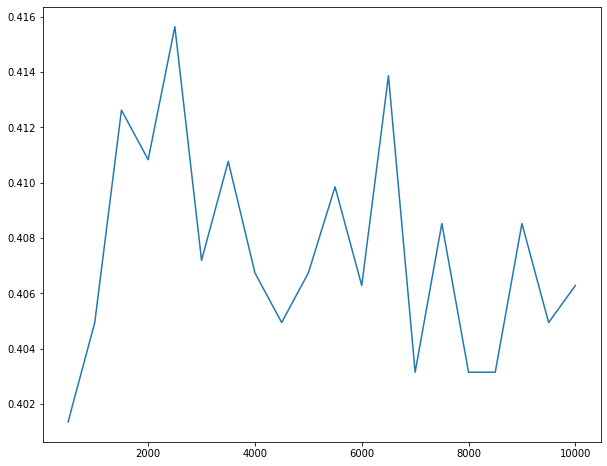

In [ ]:
n = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
results = []
for i in n:
    model = LGBMClassifier(n_estimators=i)
    model.fit(X_train, y_train)
    results.append(f1_score(y_test, model.predict(X_test)))
    print('For n_estimator: ', i, 'we get score: ', f1_score(y_test, model.predict(X_test)))
    print('***************************************')
plt.figure(figsize=(10,8))
pd.Series(results, n).plot();
print(np.max(results))

In [ ]:
model = LogisticRegression(penalty='l1', C=8.0,multi_class='auto', solver='saga')
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f1_score(y_train, train_pred))
#print(f1_score(y_test, test_pred))

0.4982332155477033


In [ ]:
model = RandomForestClassifier(n_estimators=800, oob_score=True)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f1_score(y_train, train_pred))
print(f1_score(y_test, test_pred))

0.8349514563106796
0.3423645320197044


In [ ]:
model = XGBClassifier(n_estimators=500)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f1_score(y_train, train_pred))
print(f1_score(y_test, test_pred))

0.7209705372616985
0.44339622641509435


In [ ]:
model = LGBMClassifier(n_estimators=500)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f1_score(y_train, train_pred))
print(f1_score(y_test, test_pred))

0.8335146898803046
0.2579821200510856


In [ ]:
from pandas import set_option
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

In [ ]:
def modeling():
    models = [LogisticRegression(penalty='l1', C=1.0,multi_class='auto', solver='saga'), RidgeClassifier(normalize=True, max_iter=10000, solver='saga'),
              LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=7), DecisionTreeClassifier(),
          GaussianNB(), AdaBoostClassifier(n_estimators=1500),RandomForestClassifier(n_estimators=1500),
           ExtraTreesClassifier(n_estimators=1200), XGBClassifier(n_estimators=1500),
          LGBMClassifier(n_estimators=1500, boosting_type='goss'), CatBoostClassifier(n_estimators=1500, verbose=0)]
    f1 = []
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        f1.append(f1_score(y_test, pred))
        print('For model', model, 'F1 score that we are getting is: ', f1_score(y_test, pred))
    return model, f1

In [ ]:
name, results = modeling()

For model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) F1 score that we are getting is:  0.11090573012939002
For model RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=10000, normalize=True, random_state=None,
                solver='saga', tol=0.001) F1 score that we are getting is:  0.012195121951219514
For model LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) F1 score that we are getting is:  0.18779342723004694
For model KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_nei

In [ ]:
sub = pd.DataFrame()
sub['ID'] = test.ID
sub['target'] = predict
sub.to_csv('lgbm.csv', index= False)

In [ ]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(20,18))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [ ]:
def r2(rf, X_train, y_train):
    return f1_score(y_train, model.predict(X_train))

In [ ]:
perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

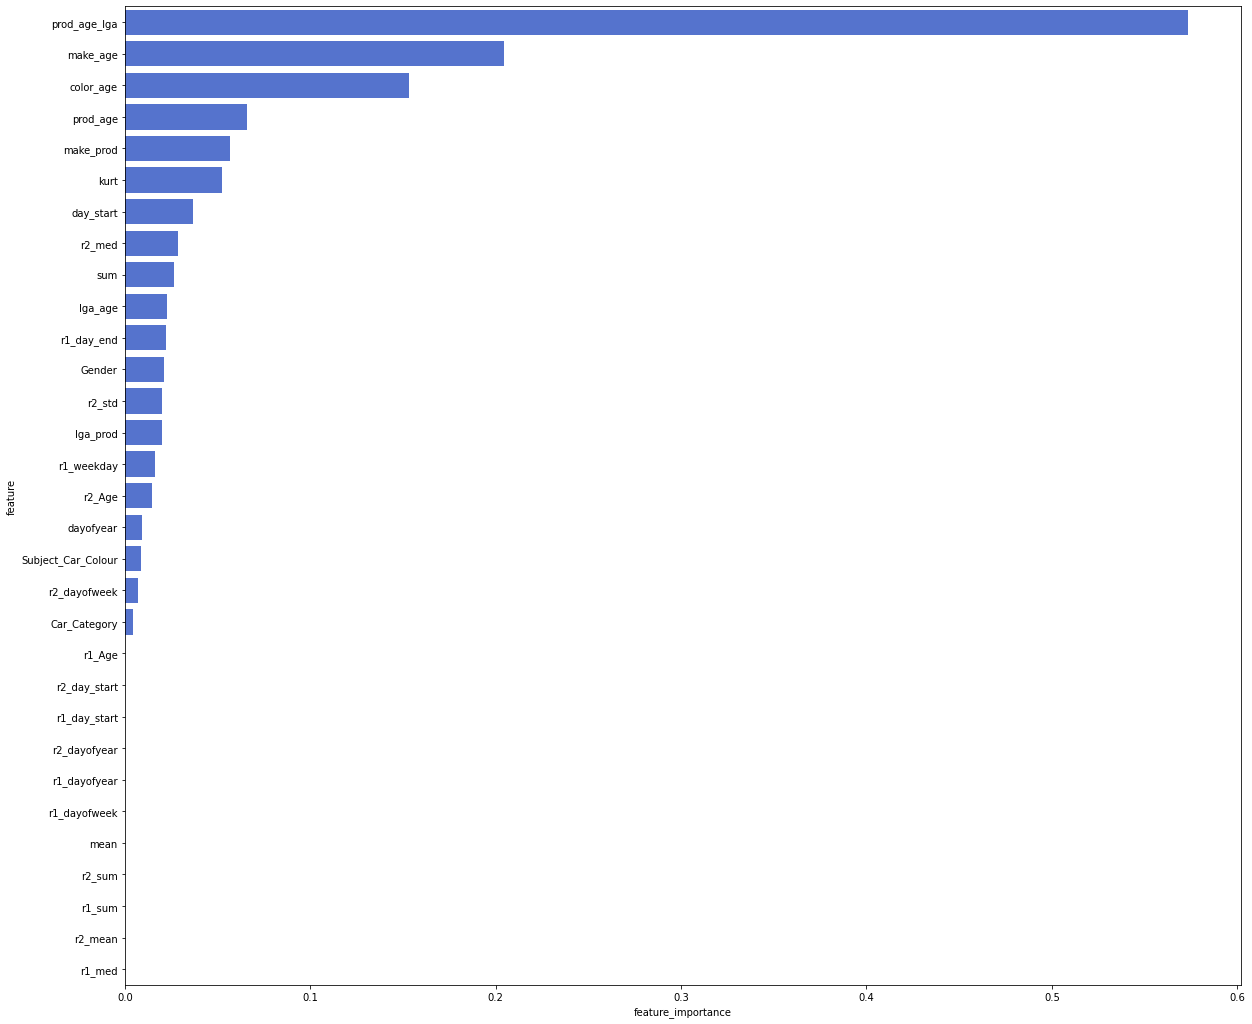

In [ ]:
var_imp_plot(perm_imp_rfpimp)

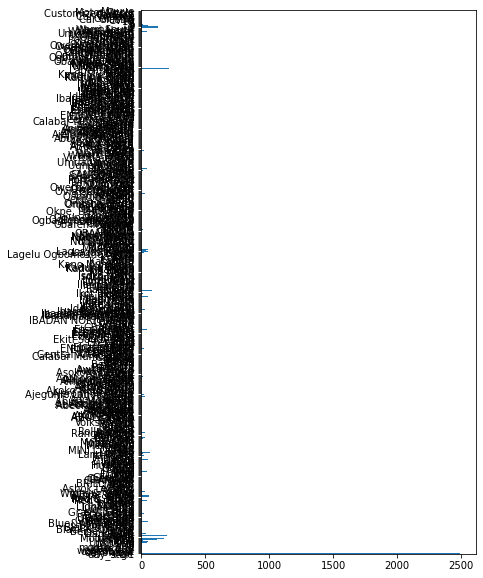

In [ ]:
plt.figure(figsize=(6,10))
(pd.Series(model.feature_importances_, index=X.columns).plot(kind= 'barh'))

In [ ]:
result = []
kf = TimeSeriesSplit(n_splits=10, max_train_size=None)
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]

    modeling = LGBMClassifier(n_estimators=2500)
    modeling.fit(X_tr, y_tr)
    pred = modeling.predict(X_tst)
    predict = modeling.predict(X_test)
    result.append(f1_score(y_tst, pred))
    print('********************************')
    print('Train f1:', f1_score(y_tr, modeling.predict(X_tr)))
    #print('Test f1:', f1_score(y_test, predict))
print('Final score', np.mean(result))#37.1688 #38.26
#plt.figure(figsize=(6,10))
#(pd.Series(modeling.feature_importances_, index=X.columns).plot(kind= 'barh'))

********************************
Train f1: 0.9660377358490566
********************************
Train f1: 0.9533468559837729
********************************
Train f1: 0.9299867899603699
********************************
Train f1: 0.9080348499515972
********************************
Train f1: 0.8818897637795277
********************************
Train f1: 0.8716956802063185
********************************
Train f1: 0.8519537699504678
********************************
Train f1: 0.8318246784182944
********************************
Train f1: 0.8161916563403552
********************************
Train f1: 0.7989357658684912
Final score 0.4010546523093951
